###  The goal of this is to help inform the email/push strategy for 14D active users to drive conversion and loyalty, reduce churn and unsubscribes. There are ideas about restricting the number of mass sends (shop and especially consumer) to these active uses in order to focus only on purchase-driven emails and reduce noise. 

#### Open to any suggestions from you on what insights may help uncover opportunities for Lifecycle at the bottom of the funnel. 

In [1]:
from pyhive import presto
import operator

def get_presto_conn():
    return presto.connect(host='presto-alpha-backend.data.houzz.net', port=8086)

def presto_query(query, presto_conn, fetchall=True):
    cursor = presto_conn.cursor()
    cursor.execute(query)
    header = list(map(operator.itemgetter(0), cursor.description))
    return header, cursor.fetchall()

conn = get_presto_conn() # establish the connection

import pandas as pd
pd.set_option('float_format', '{:f}'.format)

### How many emails do they receive? Out of them how many open/click? 
    - What emails drive most unsubs? Do we notice that they stop opening emails at some point?   
       
Ideally, we'd want to look at both consumer and MPL, and break down the engagement by email type and campaign, but let me know what is doable.  Slice by purchasers and non-purchasers. 

#### Get campaigns they received, min dt of received, max dt open and max dt click

In [338]:
q = '''
with active_users as(
select user_id
from l2.session_analytics
where dt between '2021-11-09' and '2021-11-23'
group by user_id
having sum(browse_products + cart_add + checkout_billing_and_payment + checkout_launch + checkout_shipping +
            checkout_order_review + checkout_order_confirmation + view_cart + view_product + cart_remove) > 0
)

select b.user_id
    , b.campaign_name
    , b.dt
    , case when count(b1.event_id) > 0 then 1 else 0 end opens
    , case when count(b2.event_id) > 0 then 1 else 0 end clicks
    , case when count(b3.event_id) > 0 then 1 else 0 end unsubs
from bls.blueshift_events b
    inner join active_users a
        on b.user_id = cast(a.user_id as varchar)
    left join bls.blueshift_events b1
        on b.user_id = b1.user_id
            and b.campaign_name = b1.campaign_name
            and b.dt <= b1.dt
            and lower(b1.event_name) like '%open%'
            and b1.dt between '2021-11-09' and '2021-11-23'
    left join bls.blueshift_events b2
        on b.user_id = b2.user_id
            and b.campaign_name = b2.campaign_name
            and b.dt <= b2.dt
            and lower(b2.event_name) like '%click%'
            and b2.dt between '2021-11-09' and '2021-11-23'
    left join bls.blueshift_events b3
        on b.user_id = b3.user_id
            and b.campaign_name = b3.campaign_name
            and b.dt <= b3.dt
            and b3.event_name = 'Email Link Clicked'
            and b3.dt between '2021-11-09' and '2021-11-23'
where b.dt between '2021-11-09' and '2021-11-23'
    and b.event_name in ('Email Delivered','Push Notification Sent')

group by 1,2,3

union all 


select cast(e.user_id as varchar)
    ,epn_name as campaign_name
    ,e.dt
    ,sum(case when is_open > 0 then 1 else 0 end) as opens
    ,sum(case when is_click > 0 then 1 else 0 end) as clicks
    ,sum(case when is_unsub > 0 then 1 else 0 end) as unsubs

from 

(
select dt, send_id, b.user_id, epn_name
FROM l2.batch_epn_send b
inner join active_users a
        on b.user_id = a.user_id
where dt between '2021-11-09' and '2021-11-23'
and epn_name != 'silent-push'
and event_type = 'email_send'
and length(trim(fail_reason)) = 0

union all

select dt, send_id, b.user_id, epn_name
FROM l2.epn_send b
inner join active_users a
        on b.user_id = a.user_id
where dt between '2021-11-09' and '2021-11-23'
and epn_name != 'silent-push'
and event_type = 'email_send'
and length(trim(fail_reason)) = 0
) e

left join 
(
select distinct send_id, b.user_id,
if(event_type = 'nlpv', 1, 0) as is_open,
if(event_type in ('nllc','nlac'), 1, 0) as is_click, -- nllc is regular click, nlac is click on ad banner
if(event_type = 'en_optout', 1, 0) as is_unsub
--distinct actions per user per email
from l2.epn_send_action_daily b
inner join active_users a
        on b.user_id = a.user_id
where date(dt) between date('2021-11-09') and date_add('day',7,date('2021-11-23'))
and event_type in ('nlpv','nllc','nlac','en_optout')
and send_id is not NULL
) a

on e.send_id = a.send_id
group by 1,2,3
'''

In [339]:
%%time
result = pd.read_sql_query(q, conn)

result

CPU times: user 11.3 s, sys: 1.1 s, total: 12.4 s
Wall time: 4min 41s


,user_id,campaign_name,dt,opens,clicks,unsubs
0,68214563,Price Drop Email,2021-11-17,0,0,0
1,68812574,111521 - Pro Newsletter Designers - Email,2021-11-17,0,0,0
2,70704914,Trending Photo - Email Recurring,2021-11-17,0,0,0
3,1428541,111521 - Pro Newsletter Designers - Email,2021-11-17,0,0,0
4,9064683,Back In Stock Email,2021-11-17,1,1,1
...,...,...,...,...,...,...
2302075,8239700,community-interest-photo-email2,2021-11-11,0,0,0
2302076,67683532,newsletter_editorial_v1,2021-11-17,0,0,0
2302077,70733486,newsletter_editorial_v1,2021-11-17,0,0,0
2302078,64859793,proactive_discount_email,2021-11-17,1,1,0


In [340]:
mpl_email = ['price','stock','cart','freq','products','shop']


result['mpl'] = 0
for i in mpl_email:
    result.loc[result['campaign_name'].str.lower().str.contains(i),'mpl'] = 1

In [341]:
mpl_summary = result[result['mpl']==1].groupby('user_id').agg({'campaign_name':'count','mpl':'sum'
                               ,'opens':'sum','clicks':'sum','unsubs':'sum'}).reset_index()

In [343]:
mpl_summary[['campaign_name','mpl','opens','clicks','unsubs']].mean()

campaign_name   4.899469
mpl             4.899469
opens           1.136078
clicks          0.254529
unsubs          0.225948
dtype: float64

In [498]:
q = '''
with active_users as(
select user_id
from l2.session_analytics
where dt between '2021-11-09' and '2021-11-23'
group by user_id
having sum(checkout_order_confirmation) > 0
)

select b.user_id
    , b.campaign_name
    , b.dt
    , case when count(b1.event_id) > 0 then 1 else 0 end opens
    , case when count(b2.event_id) > 0 then 1 else 0 end clicks
    , case when count(b3.event_id) > 0 then 1 else 0 end unsubs
from bls.blueshift_events b
    inner join active_users a
        on b.user_id = cast(a.user_id as varchar)
    left join bls.blueshift_events b1
        on b.user_id = b1.user_id
            and b.campaign_name = b1.campaign_name
            and b.dt <= b1.dt
            and lower(b1.event_name) like '%open%'
            and b1.dt between '2021-11-09' and '2021-11-23'
    left join bls.blueshift_events b2
        on b.user_id = b2.user_id
            and b.campaign_name = b2.campaign_name
            and b.dt <= b2.dt
            and lower(b2.event_name) like '%click%'
            and b2.dt between '2021-11-09' and '2021-11-23'
    left join bls.blueshift_events b3
        on b.user_id = b3.user_id
            and b.campaign_name = b3.campaign_name
            and b.dt <= b3.dt
            and b3.event_name = 'Email Link Clicked'
            and b3.dt between '2021-11-09' and '2021-11-23'
where b.dt between '2021-11-09' and '2021-11-23'
    and b.event_name in ('Email Delivered','Push Notification Sent')

group by 1,2,3

union all 


select cast(e.user_id as varchar)
    ,epn_name as campaign_name
    ,e.dt
    ,sum(case when is_open > 0 then 1 else 0 end) as opens
    ,sum(case when is_click > 0 then 1 else 0 end) as clicks
    ,sum(case when is_unsub > 0 then 1 else 0 end) as unsubs

from 

(
select dt, send_id, b.user_id, epn_name
FROM l2.batch_epn_send b
inner join active_users a
        on b.user_id = a.user_id
where dt between '2021-11-09' and '2021-11-23'
and epn_name != 'silent-push'
and event_type = 'email_send'
and length(trim(fail_reason)) = 0

union all

select dt, send_id, b.user_id, epn_name
FROM l2.epn_send b
inner join active_users a
        on b.user_id = a.user_id
where dt between '2021-11-09' and '2021-11-23'
and epn_name != 'silent-push'
and event_type = 'email_send'
and length(trim(fail_reason)) = 0
) e

left join 
(
select distinct send_id, b.user_id,
if(event_type = 'nlpv', 1, 0) as is_open,
if(event_type in ('nllc','nlac'), 1, 0) as is_click, -- nllc is regular click, nlac is click on ad banner
if(event_type = 'en_optout', 1, 0) as is_unsub
--distinct actions per user per email
from l2.epn_send_action_daily b
inner join active_users a
        on b.user_id = a.user_id
where date(dt) between date('2021-11-09') and date_add('day',7,date('2021-11-23'))
and event_type in ('nlpv','nllc','nlac','en_optout')
and send_id is not NULL
) a

on e.send_id = a.send_id
group by 1,2,3
'''

In [500]:
%%time
xo_active_users = pd.read_sql_query(q, conn)

xo_active_users

CPU times: user 1.75 s, sys: 1.05 s, total: 2.8 s
Wall time: 1min 18s


,user_id,campaign_name,dt,opens,clicks,unsubs
0,69239517,Freq Bought Together - Return Purchaser - Email,2021-11-10,1,0,0
1,67573953,11112021 NEW - Shop Houzz - Email,2021-11-11,0,0,0
2,68356852,11112021 NEW - Shop Houzz - Email,2021-11-11,1,1,1
3,65618913,11112021 NEW - Shop Houzz - Email,2021-11-11,0,0,0
4,26387106,Browse Professionals Abandonment Series V3 - E...,2021-11-22,0,0,0
...,...,...,...,...,...,...
289302,3166116,community-project-email,2021-11-19,0,0,0
289303,70698289,newsletter_editorial_v1,2021-11-22,1,0,0
289304,60485962,community-interest-photo-email,2021-11-16,0,0,0
289305,70810007,order_delivered_email_us,2021-11-21,1,0,0


Text(0.5, 1.0, 'Emails received by xo users')

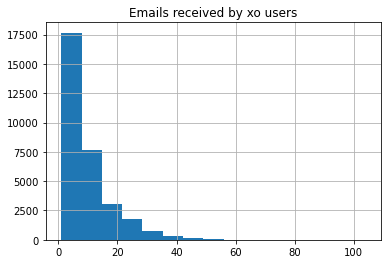

In [538]:
xo_active_users.groupby('user_id')[['campaign_name']].count().hist(bins=15)
plt.title('Emails received by xo users')

Text(0.5, 1.0, 'Emails received by xo users')

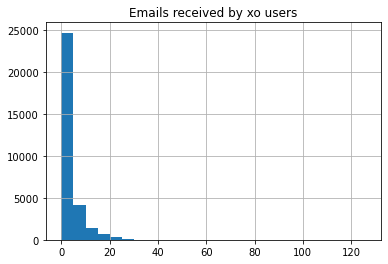

In [543]:
xo_active_users.groupby('user_id')[['opens']].sum().hist(bins=25)
plt.title('Emails received by xo users')

In [541]:
xo_active_users.groupby('user_id')[['opens']].sum().describe()

,opens
count,31509.000000
mean,3.903361
std,4.881998
min,0.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,126.000000


In [502]:
xo_active_users['mpl'] = 0
for i in mpl_email:
    xo_active_users.loc[result['campaign_name'].str.lower().str.contains(i),'mpl'] = 1

In [503]:
xo_active_users_summary = xo_active_users.groupby('user_id').agg({'campaign_name':'count','mpl':'sum'
                               ,'opens':'sum','clicks':'sum','unsubs':'sum'}).reset_index()

In [505]:
xo_active_users_summary[['campaign_name','mpl','opens','clicks','unsubs']].mean()

campaign_name   9.181726
mpl             8.326669
opens           3.903361
clicks          0.372148
unsubs          0.163572
dtype: float64

In [530]:
mpl_xo_active_users_summary = xo_active_users[xo_active_users['mpl']==1].groupby('user_id').agg({'campaign_name':'count'
                            ,'mpl':'sum','opens':'sum','clicks':'sum','unsubs':'sum'}).reset_index()

mpl_xo_active_users_summary[['campaign_name','mpl','opens','clicks','unsubs']].mean()

campaign_name   8.410752
mpl             8.410752
opens           3.572033
clicks          0.342374
unsubs          0.150734
dtype: float64

In [531]:
0.150734/0.163572

0.9215146846648571

In [533]:
xo_active_users[xo_active_users['unsubs']>0]['campaign_name'].value_counts()

11212021 - Shop Houzz - Email                          563
11182021 - Shop Houzz - Email                          558
11232021 - Shop Houzz - Email                          487
Cart Reminder - V3 - Email                             474
Freq Bought Together - First Time Purchaser - Email    463
Cart Reminder V1 - Email 50/50                         398
Cart Reminder - V2 - Email                             397
Freq Bought Together - Return Purchaser - Email        340
11142021 - Shop Houzz - Email                          332
11092021 - Shop Houzz - Email                          258
11112021 NEW - Shop Houzz - Email                      166
Price Drop Email                                       121
Related Products/People Also Liked - Email              81
newsletter_editorial_v1                                 65
Back In Stock Email                                     57
community-project-email                                 51
11182021 - Shop Houzz - LC - Email                      

In [512]:
q = '''
with active_users as(
select user_id
from l2.session_analytics
where dt between '2021-11-09' and '2021-11-23'
group by user_id
having sum(checkout_order_confirmation) = 0 
    and sum(browse_products + cart_add + checkout_billing_and_payment + checkout_launch + checkout_shipping +
            checkout_order_review + view_cart + view_product + cart_remove) > 0
)

select b.user_id
    , b.campaign_name
    , b.dt
    , case when count(b1.event_id) > 0 then 1 else 0 end opens
    , case when count(b2.event_id) > 0 then 1 else 0 end clicks
    , case when count(b3.event_id) > 0 then 1 else 0 end unsubs
from bls.blueshift_events b
    inner join active_users a
        on b.user_id = cast(a.user_id as varchar)
    left join bls.blueshift_events b1
        on b.user_id = b1.user_id
            and b.campaign_name = b1.campaign_name
            and b.dt <= b1.dt
            and lower(b1.event_name) like '%open%'
            and b1.dt between '2021-11-09' and '2021-11-23'
    left join bls.blueshift_events b2
        on b.user_id = b2.user_id
            and b.campaign_name = b2.campaign_name
            and b.dt <= b2.dt
            and lower(b2.event_name) like '%click%'
            and b2.dt between '2021-11-09' and '2021-11-23'
    left join bls.blueshift_events b3
        on b.user_id = b3.user_id
            and b.campaign_name = b3.campaign_name
            and b.dt <= b3.dt
            and b3.event_name = 'Email Link Clicked'
            and b3.dt between '2021-11-09' and '2021-11-23'
where b.dt between '2021-11-09' and '2021-11-23'
    and b.event_name in ('Email Delivered','Push Notification Sent')

group by 1,2,3

union all 


select cast(e.user_id as varchar)
    ,epn_name as campaign_name
    ,e.dt
    ,sum(case when is_open > 0 then 1 else 0 end) as opens
    ,sum(case when is_click > 0 then 1 else 0 end) as clicks
    ,sum(case when is_unsub > 0 then 1 else 0 end) as unsubs

from 

(
select dt, send_id, b.user_id, epn_name
FROM l2.batch_epn_send b
inner join active_users a
        on b.user_id = a.user_id
where dt between '2021-11-09' and '2021-11-23'
and epn_name != 'silent-push'
and event_type = 'email_send'
and length(trim(fail_reason)) = 0

union all

select dt, send_id, b.user_id, epn_name
FROM l2.epn_send b
inner join active_users a
        on b.user_id = a.user_id
where dt between '2021-11-09' and '2021-11-23'
and epn_name != 'silent-push'
and event_type = 'email_send'
and length(trim(fail_reason)) = 0
) e

left join 
(
select distinct send_id, b.user_id,
if(event_type = 'nlpv', 1, 0) as is_open,
if(event_type in ('nllc','nlac'), 1, 0) as is_click, -- nllc is regular click, nlac is click on ad banner
if(event_type = 'en_optout', 1, 0) as is_unsub
--distinct actions per user per email
from l2.epn_send_action_daily b
inner join active_users a
        on b.user_id = a.user_id
where date(dt) between date('2021-11-09') and date_add('day',7,date('2021-11-23'))
and event_type in ('nlpv','nllc','nlac','en_optout')
and send_id is not NULL
) a

on e.send_id = a.send_id
group by 1,2,3
'''

In [513]:
%%time
none_xo_active_users = pd.read_sql_query(q, conn)

none_xo_active_users

CPU times: user 11.1 s, sys: 2.06 s, total: 13.2 s
Wall time: 3min 31s


,user_id,campaign_name,dt,opens,clicks,unsubs
0,65304159,11232021 - Shop Houzz - Email,2021-11-23,0,0,0
1,68652054,11232021 - Shop Houzz - LC - Email,2021-11-23,1,1,1
2,69847188,11232021 - Shop Houzz - Email,2021-11-23,1,0,0
3,70748052,11232021 - Shop Houzz - Email,2021-11-23,1,0,0
4,70762249,11232021 - Shop Houzz - Email,2021-11-23,0,0,0
...,...,...,...,...,...,...
2012768,65023354,community-interest-photo-email2,2021-11-19,0,0,0
2012769,11274357,newsletter_editorial_v1,2021-11-21,0,0,0
2012770,17060346,community-project-email,2021-11-19,1,0,0
2012771,68760172,interest-story-email,2021-11-19,1,0,0


In [514]:
none_xo_active_users['mpl'] = 0
for i in mpl_email:
    none_xo_active_users.loc[result['campaign_name'].str.lower().str.contains(i),'mpl'] = 1

In [515]:
none_xo_active_users_summary = none_xo_active_users.groupby('user_id').agg({'campaign_name':'count','mpl':'sum'
                               ,'opens':'sum','clicks':'sum','unsubs':'sum'}).reset_index()

none_xo_active_users_summary[['campaign_name','mpl','opens','clicks','unsubs']].mean()

campaign_name   10.540507
mpl              3.670243
opens            3.177653
clicks           0.754807
unsubs           0.170327
dtype: float64

In [544]:
mpl_none_xo_active_users_summary = none_xo_active_users[none_xo_active_users['mpl']==1].groupby('user_id').agg({
    'campaign_name':'count'
                            ,'mpl':'sum','opens':'sum','clicks':'sum','unsubs':'sum'}).reset_index()

mpl_none_xo_active_users_summary[['campaign_name','mpl','opens','clicks','unsubs']].mean()

campaign_name   4.618271
mpl             4.618271
opens           1.117517
clicks          0.245939
unsubs          0.181125
dtype: float64

In [547]:
none_xo_active_users[none_xo_active_users['unsubs']>0]['campaign_name'].value_counts()[:25]

11182021 - Shop Houzz - Email                 3516
11212021 - Shop Houzz - Email                 3379
11232021 - Shop Houzz - Email                 2854
11092021 - Shop Houzz - Email                 2602
11112021 NEW - Shop Houzz - Email             2507
11142021 - Shop Houzz - Email                 2437
Cart Reminder - V3 - Email                    1604
Cart Reminder - V2 - Email                    1505
Related Products/People Also Liked - Email    1475
Cart Reminder V1 - Email 50/50                1367
newsletter_editorial_v1                       1099
11182021 - Shop Houzz - LC - Email            1048
11142021 - Shop Houzz - LC - Email             776
Price Drop Email                               636
Interest Photo - Email Recurring               533
11212021 - Shop Houzz - LC - Email             496
11232021 - Shop Houzz - LC - Email             468
community-project-email                        434
11082021 - Shop Houzz - Email                  394
111221 - Pro Newsletter Designe

In [548]:
none_xo_active_users.groupby('user_id')[['opens']].sum().describe()

,opens
count,190956.000000
mean,3.177653
std,5.085594
min,0.000000
25%,0.000000
50%,1.000000
75%,4.000000
max,343.000000


- How many emails do they receive? Out of them how many open/click? 
    - In average, 9.8 emails in 14 days. 2.7 out of them are marketplace emails.
    - They open 3 emails and clicks 0.65 emails in average.
    - They open 1.13 mpl emails amd a-fifth of open unsubscribe
   
- What emails drive most unsubs? Do we notice that they stop opening emails at some point? 
    - Mostly Shop Houzz & Cart Reminder; occupying **66%** of total unsubscribe
    
---
#### For those who make an order
    - In average, received 9.2 emails with 8.3 of them are marketplace emails
    - Opened 3.9, click 0.4, and 16% of the unsubscribe

#### For those who didn't make an order
    - In average, received 10.5 with 3.7 marketplace emails
    - Opened 3.2, clicked 0.75, and 17% of them unsubscribe
    
#### To change a way, maybe we should let those who show mpl intent show more engagement in consumer side. And reduce MPL campaigns until they increase motivation to MPL again. (Long-term customer values instead of pushing them to purchase in short time.

In [40]:
summary = result.groupby('user_id').agg({'campaign_name':'count','mpl':'sum'
                               ,'opens':'sum','clicks':'sum','unsubs':'sum'}).reset_index()

In [41]:
summary[['campaign_name','mpl','opens','clicks','unsubs']].mean()

campaign_name   9.801415
mpl             2.707632
opens           2.974770
clicks          0.646891
unsubs          0.152854
dtype: float64

In [47]:
result[result['unsubs']>0]['campaign_name'].value_counts()[:8].sum()/result[result['unsubs']>0].shape[0]

0.6608281240329269

Text(0.5, 1.0, 'Emails received in 2 weeks')

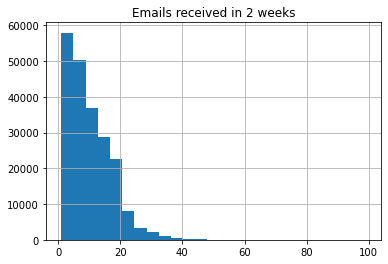

In [462]:
summary.campaign_name.hist(bins=25)
plt.title('Emails received in 2 weeks')

In [105]:
summary[summary['campaign_name']>10]['opens'].describe()

count   83262.000000
mean        5.245370
std         6.219442
min         0.000000
25%         0.000000
50%         3.000000
75%         9.000000
max       307.000000
Name: opens, dtype: float64

In [107]:
summary[summary['campaign_name']>10]['clicks'].describe()

count   83262.000000
mean        1.294985
std         2.237155
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max        92.000000
Name: clicks, dtype: float64

In [108]:
summary[summary['campaign_name']>10]['unsubs'].describe()

count   83262.000000
mean        0.239461
std         0.674465
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        13.000000
Name: unsubs, dtype: float64

### 15% of the 14D active users unsubscribe in past 14 days. Shop Houzz and Cart Reminder drive 66% of the unsubscription.

User row number window function to rank email order from user receiving perspective so that we can know more about open and unsubscribe behaviors.

In [506]:
q = '''
with active_users as(
select user_id
from l2.session_analytics
where dt between '2021-11-09' and '2021-11-23'
group by user_id
having sum(browse_products + cart_add + checkout_billing_and_payment + checkout_launch + checkout_shipping +
            checkout_order_review + checkout_order_confirmation + view_cart + view_product + cart_remove) > 0
)

,processed as(
select b.user_id
    , b.campaign_name
    , b.dt
    , case when count(b1.event_id) > 0 then 1 else 0 end opens
    , case when count(b2.event_id) > 0 then 1 else 0 end clicks
    , case when count(b3.event_id) > 0 then 1 else 0 end unsubs
from bls.blueshift_events b
    inner join active_users a
        on b.user_id = cast(a.user_id as varchar)
    left join bls.blueshift_events b1
        on b.user_id = b1.user_id
            and b.campaign_name = b1.campaign_name
            and b.dt <= b1.dt
            and lower(b1.event_name) like '%open%'
            and b1.dt between '2021-11-09' and '2021-11-23'
    left join bls.blueshift_events b2
        on b.user_id = b2.user_id
            and b.campaign_name = b2.campaign_name
            and b.dt <= b2.dt
            and lower(b2.event_name) like '%click%'
            and b2.dt between '2021-11-09' and '2021-11-23'
    left join bls.blueshift_events b3
        on b.user_id = b3.user_id
            and b.campaign_name = b3.campaign_name
            and b.dt <= b3.dt
            and b3.event_name = 'Email Link Clicked'
            and b3.dt between '2021-11-09' and '2021-11-23'
where b.dt between '2021-11-09' and '2021-11-23'
    and b.event_name in ('Email Delivered','Push Notification Sent')

group by 1,2,3

union all 


select cast(e.user_id as varchar)
    ,epn_name as campaign_name
    ,e.dt
    ,sum(case when is_open > 0 then 1 else 0 end) as opens
    ,sum(case when is_click > 0 then 1 else 0 end) as clicks
    ,sum(case when is_unsub > 0 then 1 else 0 end) as unsubs

from 

(
select dt, send_id, b.user_id, epn_name
FROM l2.batch_epn_send b
inner join active_users a
        on b.user_id = a.user_id
where dt between '2021-11-09' and '2021-11-23'
and epn_name != 'silent-push'
and event_type = 'email_send'
and length(trim(fail_reason)) = 0

union all

select dt, send_id, b.user_id, epn_name
FROM l2.epn_send b
inner join active_users a
        on b.user_id = a.user_id
where dt between '2021-11-09' and '2021-11-23'
and epn_name != 'silent-push'
and event_type = 'email_send'
and length(trim(fail_reason)) = 0
) e

left join 
(
select distinct send_id, b.user_id,
if(event_type = 'nlpv', 1, 0) as is_open,
if(event_type in ('nllc','nlac'), 1, 0) as is_click, -- nllc is regular click, nlac is click on ad banner
if(event_type = 'en_optout', 1, 0) as is_unsub
--distinct actions per user per email
from l2.epn_send_action_daily b
inner join active_users a
        on b.user_id = a.user_id
where date(dt) between date('2021-11-09') and date_add('day',7,date('2021-11-23'))
and event_type in ('nlpv','nllc','nlac','en_optout')
and send_id is not NULL
) a

on e.send_id = a.send_id
group by 1,2,3)

select *
    , rank() over(partition by user_id order by dt) receive_order
from processed
'''

In [507]:
%%time
window = pd.read_sql_query(q, conn)

window

CPU times: user 13.7 s, sys: 3.18 s, total: 16.8 s
Wall time: 3min 56s


,user_id,campaign_name,dt,opens,clicks,unsubs,receive_order
0,10040465,community-interest-photo-email,2021-11-09,1,0,0,1
1,10040465,newsletter_editorial_v1,2021-11-10,1,0,0,2
2,10040465,community-interest-photo-email2,2021-11-11,0,0,0,3
3,10040465,interest-story-email,2021-11-12,1,0,0,4
4,10040465,community-project-email,2021-11-12,1,1,0,4
...,...,...,...,...,...,...,...
2302075,9980237,11212021 - Shop Houzz - Email,2021-11-22,0,0,0,20
2302076,9980237,trending-room-photo-email,2021-11-22,0,0,0,20
2302077,9980237,11232021 - Shop Houzz - Email,2021-11-23,0,0,0,22
2302078,9980237,community-interest-photo-email,2021-11-23,0,0,0,22


In [509]:
window[window['opens']>0].groupby('user_id').agg({'receive_order':'min'}).reset_index().describe()

,receive_order
count,135413.000000
mean,2.579221
std,3.116013
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,44.000000


<AxesSubplot:>

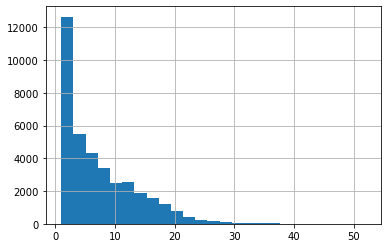

In [82]:
window[window['unsubs']>0]['_col6'].hist(bins=25)

In [85]:
window[window['unsubs']>0]['_col6'].describe()

count   37607.000000
mean        7.558859
std         6.358089
min         1.000000
25%         2.000000
50%         6.000000
75%        11.000000
max        52.000000
Name: _col6, dtype: float64

### unsub vs not unsub (cart reminder & shop houzz)

<AxesSubplot:>

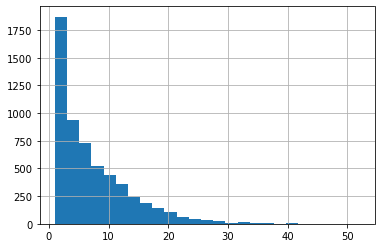

In [87]:
result[(result['campaign_name'].str.lower().str.contains('cart'))&(result['unsubs']>0)]['_col6'].hist(bins=25)

In [90]:
result[(result['campaign_name'].str.lower().str.contains('cart'))&(result['unsubs']>0)]['_col6'].describe()

count   5745.000000
mean       7.483899
std        6.448002
min        1.000000
25%        3.000000
50%        6.000000
75%       11.000000
max       52.000000
Name: _col6, dtype: float64

<AxesSubplot:>

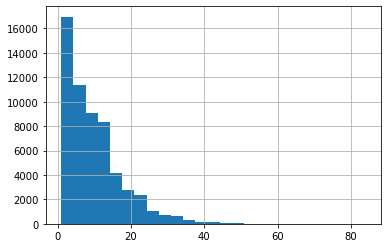

In [89]:
result[(result['campaign_name'].str.lower().str.contains('cart'))&(result['unsubs']==0)]['_col6'].hist(bins=25)

In [91]:
result[(result['campaign_name'].str.lower().str.contains('cart'))&(result['unsubs']==0)]['_col6'].describe()

count   58002.000000
mean        9.620720
std         7.731070
min         1.000000
25%         4.000000
50%         8.000000
75%        13.000000
max        84.000000
Name: _col6, dtype: float64

<AxesSubplot:>

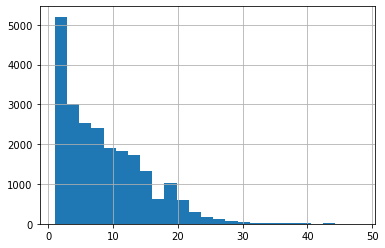

In [94]:
result[(result['campaign_name'].str.lower().str.contains('shop'))&(result['unsubs']>0)]['_col6'].hist(bins=25)

In [95]:
result[(result['campaign_name'].str.lower().str.contains('shop'))&(result['unsubs']>0)]['_col6'].describe()

count   23048.000000
mean        8.512713
std         6.663077
min         1.000000
25%         3.000000
50%         7.000000
75%        13.000000
max        48.000000
Name: _col6, dtype: float64

<AxesSubplot:>

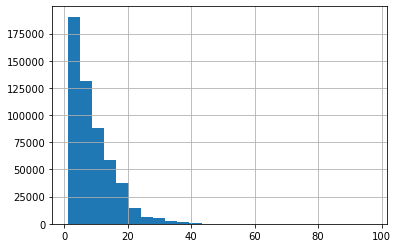

In [96]:
result[(result['campaign_name'].str.lower().str.contains('shop'))&(result['unsubs']==0)]['_col6'].hist(bins=25)

In [97]:
result[(result['campaign_name'].str.lower().str.contains('shop'))&(result['unsubs']==0)]['_col6'].describe()

count   536785.000000
mean         8.426258
std          6.890264
min          1.000000
25%          3.000000
50%          7.000000
75%         12.000000
max         97.000000
Name: _col6, dtype: float64

<AxesSubplot:>

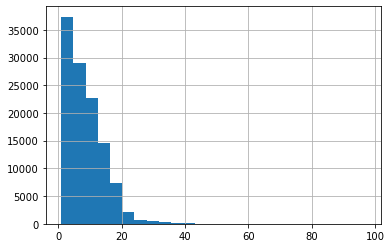

In [101]:
result[(result['clicks']>0)&(result['unsubs']==0)]['_col6'].hist(bins=25)

### There are two types of users. Some of them receive more than 10 emails who rarely react and unsubscribe. And those who receive less than 10 but unsubscribe soon.

### For users who have not made a purchase but shown intent, can we identify what helps them convert? Slice by account age
    - What behavior do those converting users show? 
       
        - They have fast conversion and concentrate behavior in MPL. To match, we can check if they are from PLA or direct search. (Urge to purchase) And thus keep them using consumer features (photos, projects, and ideabooks) and send shop houzz only during shopping seasons or when they show more intent
           
    - How many sessions on average does a user make before converting? 
        - 8.35 sessions while 75% of them make first order within 7 sessions.
    - How can an email/push help with product discovery and conversion? 
    - Can we make a hypothesis that a discount may drive first-time purchases?
    
* Get user account created journey for those active users
* Check first purchase for price drop

In [518]:
q = '''
with active_users as(
select user_id
    ,case when sum(checkout_order_confirmation) > 0 then 'xo_users'
        else 'active_wo_xo' end user_type
from l2.session_analytics
where dt between '2021-11-09' and '2021-11-23'
group by user_id
having sum(browse_products + cart_add + checkout_billing_and_payment + checkout_launch + checkout_shipping +
            checkout_order_review + checkout_order_confirmation + view_cart + view_product + cart_remove) > 0
), account_info as(
select c.user_id, user_type
    ,substring(c.created, 1, 10) as create_dt
from c2.users c
    inner join active_users a
        on c.user_id = a.user_id
)

select a.user_id
    , user_type
    , a.create_dt
    , count(distinct session_id) sessions
    , sum(add_to_ideabook) add_to_ideabook
    , sum(browse_photos) browse_photos
    , sum(browse_products) browse_products
    , sum(browse_discussions) browse_discussions
    , sum(browse_professionals) browse_professionals
    , sum(browse_ideabooks) browse_ideabooks
    , sum(cart_add) cart_add
    , sum(checkout_billing_and_payment) checkout_billing_and_payment
    , sum(checkout_launch) checkout_launch
    , sum(checkout_shipping) checkout_shipping
    , sum(checkout_order_review) checkout_order_review
    , sum(checkout_order_confirmation) checkout_order_confirmation
    , sum(view_cart) view_cart
    , sum(view_photo) view_photo
    , sum(view_product) view_product
    , sum(view_discussion) view_discussion
    , sum(browse_user_reviews) browse_user_reviews
    , sum(browse_user_photos) browse_user_photos
    , sum(browse_user_ideabooks) browse_user_ideabooks
    , sum(view_project) view_project
    , sum(search_photos) search_photos
    , sum(search_products) search_products
    , sum(add_product_to_ideabook) add_product_to_ideabook
from account_info a
    left join l2.session_analytics l
        on l.user_id = a.user_id
            and l.dt between '2021-11-09' and '2021-11-23'
group by 1,2,3

'''

In [519]:
%%time
engagement = pd.read_sql_query(q, conn)

engagement

CPU times: user 4.51 s, sys: 7.02 s, total: 11.5 s
Wall time: 3min 28s


,user_id,user_type,create_dt,sessions,add_to_ideabook,browse_photos,browse_products,browse_discussions,browse_professionals,browse_ideabooks,cart_add,checkout_billing_and_payment,checkout_launch,checkout_shipping,checkout_order_review,checkout_order_confirmation,view_cart,view_photo,view_product,view_discussion,browse_user_reviews,browse_user_photos,browse_user_ideabooks,view_project,search_photos,search_products,add_product_to_ideabook
0,70687856,active_wo_xo,2021-11-08,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0
1,68997716,active_wo_xo,2021-07-07,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,70159963,xo_users,2021-09-29,22,0,0,0,0,0,0,0,1,2,0,3,2,0,0,0,0,0,0,0,0,0,0,0
3,2074185,xo_users,2012-06-25,37,0,55,40,0,0,0,5,2,1,0,3,1,7,14,37,0,0,0,0,0,8,21,0
4,10494088,active_wo_xo,2013-10-27,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268441,8427820,active_wo_xo,2013-07-17,1,0,0,0,0,0,0,0,0,2,4,0,0,0,0,0,0,0,0,0,0,0,0,0
268442,70617494,active_wo_xo,2021-11-03,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
268443,31581538,active_wo_xo,2016-03-28,4,0,0,197,0,0,0,1,0,0,0,0,0,0,0,80,0,0,0,0,0,0,45,0
268444,67821740,active_wo_xo,2021-04-16,1,0,0,4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [245]:
'2021-10-15'[:7]

'2021-10'

In [521]:
engagement['create_month'] = engagement['create_dt'].apply(lambda x: x[:7])

In [524]:
engagement['create_month'].value_counts()[:15]

2021-11    39456
2021-10    12095
2021-09     7738
2021-08     6410
2021-07     5015
2021-06     4402
2021-05     3876
2021-04     3234
2021-03     3211
2013-02     3090
2013-01     2887
2021-01     2874
2021-02     2693
2013-03     2588
2014-01     2489
Name: create_month, dtype: int64

In [522]:
engagement[engagement['user_type']=='xo_users']['create_month'].value_counts()[:15]

2021-11    11993
2021-10      800
2021-09      407
2021-08      343
2013-02      280
2021-07      279
2013-01      243
2013-03      241
2021-06      239
2018-01      228
2015-01      219
2014-01      219
2017-11      216
2021-05      216
2021-04      215
Name: create_month, dtype: int64

In [523]:
engagement[engagement['user_type']=='active_wo_xo']['create_month'].value_counts()[:15]

2021-11    27463
2021-10    11295
2021-09     7331
2021-08     6067
2021-07     4736
2021-06     4163
2021-05     3660
2021-04     3019
2021-03     3008
2013-02     2810
2021-01     2684
2013-01     2644
2021-02     2508
2013-03     2347
2014-01     2270
Name: create_month, dtype: int64

In [525]:
engagement['create_year'] = engagement['create_dt'].apply(lambda x: x[:4])

### Check if these users are using consumer features

In [527]:
engagement.groupby('create_year').agg({'user_id':pd.Series.nunique})[::-1]

,user_id
create_year,
2021,91004
2020,23469
2019,14798
2018,15214
2017,17991
2016,16833
2015,17493
2014,20090
2013,26133


In [528]:
engagement[engagement['user_type']=='xo_users'].groupby('create_year').agg({'user_id':pd.Series.nunique})[::-1]

,user_id
create_year,
2021,15070
2020,1718
2019,1226
2018,1693
2017,2064
2016,1814
2015,1794
2014,1984
2013,2358


In [529]:
engagement[engagement['user_type']!='xo_users'].groupby('create_year').agg({'user_id':pd.Series.nunique})[::-1]

,user_id
create_year,
2021,75934
2020,21751
2019,13572
2018,13521
2017,15927
2016,15019
2015,15699
2014,18106
2013,23775


In [336]:
engagement[engagement['create_year']!='2021'].shape[0]/engagement.shape[0]

0.6609969975339547

In [263]:
engagement.groupby('create_year')[['sessions', 'add_to_ideabook', 'browse_photos',
       'browse_products', 'browse_discussions', 'browse_professionals',
       'browse_ideabooks', 'cart_add', 'checkout_billing_and_payment',
       'checkout_launch', 'checkout_shipping', 'checkout_order_review',
       'checkout_order_confirmation', 'view_cart', 'view_photo',
       'view_product', 'view_discussion', 'browse_user_reviews',
       'browse_user_photos', 'browse_user_ideabooks', 'view_project',
       'search_photos', 'search_products', 'add_product_to_ideabook']].mean()[::-1]

,sessions,add_to_ideabook,browse_photos,browse_products,browse_discussions,browse_professionals,browse_ideabooks,cart_add,checkout_billing_and_payment,checkout_launch,checkout_shipping,checkout_order_review,checkout_order_confirmation,view_cart,view_photo,view_product,view_discussion,browse_user_reviews,browse_user_photos,browse_user_ideabooks,view_project,search_photos,search_products,add_product_to_ideabook
create_year,,,,,,,,,,,,,,,,,,,,,,,,
2021,3.369467,0.607457,4.134258,5.420058,0.229331,0.213694,0.084744,0.398949,0.219738,0.299119,0.311756,0.317393,0.183970,0.490901,2.718661,4.593556,0.470705,0.006549,0.007681,0.015769,0.224320,1.524307,0.954925,0.148499
2020,3.809536,0.631557,4.854063,5.573011,0.339384,0.206613,0.109719,0.292940,0.088585,0.190336,0.154757,0.195321,0.082492,0.420555,4.311389,4.540330,0.646939,0.009758,0.007840,0.019558,0.292002,2.097661,1.049512,0.149815
2019,3.952899,0.715435,5.060751,5.887350,0.425193,0.195770,0.101973,0.345249,0.096162,0.222733,0.173740,0.237262,0.096229,0.508988,4.709893,4.948304,0.767469,0.005879,0.013110,0.025274,0.308690,2.255575,1.188742,0.141979
2018,4.013869,0.716117,4.777573,6.245563,0.510648,0.149533,0.104903,0.422111,0.132772,0.294006,0.227619,0.314907,0.129815,0.652886,3.460497,5.288747,0.789207,0.010122,0.007625,0.034573,0.286907,2.109965,1.304062,0.172999
2017,3.880273,0.640153,4.428937,6.254794,0.369185,0.139070,0.104108,0.423434,0.136568,0.310211,0.237730,0.334278,0.131566,0.676616,3.605858,5.365738,0.658663,0.007782,0.008171,0.032739,0.244900,1.961814,1.299483,0.191818
2016,4.296323,0.844472,5.468603,6.152439,0.417454,0.155171,0.107408,0.386859,0.127131,0.280639,0.222955,0.290085,0.123151,0.603992,4.548328,5.235727,0.760173,0.008376,0.016990,0.040219,0.313788,2.431949,1.351750,0.164974
2015,5.052821,0.989424,7.011376,6.167153,1.633110,0.189161,0.174012,0.371063,0.128051,0.277254,0.220431,0.287372,0.116675,0.622249,4.979649,5.229806,1.805351,0.009947,0.015778,0.046476,0.450409,3.152404,1.280627,0.197450
2014,4.593778,1.084719,7.369686,6.041463,0.800249,0.175460,0.149079,0.363912,0.112842,0.265555,0.203932,0.272076,0.115082,0.542160,5.293081,5.048183,1.056446,0.009457,0.016526,0.044948,0.437133,3.601145,1.342210,0.200846
2013,4.533004,1.377377,8.672177,5.923201,0.832090,0.187732,0.157349,0.343895,0.105422,0.232771,0.175678,0.253166,0.102514,0.507443,5.037118,4.766234,1.255654,0.009452,0.014120,0.059465,0.453105,4.485134,1.344775,0.218000


In [471]:
engagement.groupby('create_year')[['sessions', 'add_to_ideabook', 'browse_photos',
       'browse_discussions','view_photo','view_discussion',
       'search_photos']].mean()[::-1]

,sessions,add_to_ideabook,browse_photos,browse_discussions,view_photo,view_discussion,search_photos
create_year,,,,,,,
2021,3.369467,0.607457,4.134258,0.229331,2.718661,0.470705,1.524307
2020,3.809536,0.631557,4.854063,0.339384,4.311389,0.646939,2.097661
2019,3.952899,0.715435,5.060751,0.425193,4.709893,0.767469,2.255575
2018,4.013869,0.716117,4.777573,0.510648,3.460497,0.789207,2.109965
2017,3.880273,0.640153,4.428937,0.369185,3.605858,0.658663,1.961814
2016,4.296323,0.844472,5.468603,0.417454,4.548328,0.760173,2.431949
2015,5.052821,0.989424,7.011376,1.633110,4.979649,1.805351,3.152404
2014,4.593778,1.084719,7.369686,0.800249,5.293081,1.056446,3.601145
2013,4.533004,1.377377,8.672177,0.832090,5.037118,1.255654,4.485134


#### If Loyal customers purchase more frequent than new customers? Do they have app?

In [284]:
q = '''
with active_users as(
select user_id
from l2.session_analytics
where dt between '2021-11-09' and '2021-11-23'
group by user_id
having sum(browse_products + cart_add + checkout_billing_and_payment + checkout_launch + checkout_shipping +
            checkout_order_review + checkout_order_confirmation + view_cart + view_product + cart_remove) > 0
), account_info as(
select c.user_id
    ,substring(c.created, 1, 4) as year_created
from c2.users c
    inner join active_users a
        on c.user_id = a.user_id
)

select year_created
    ,count(distinct a.user_id) as customers
    ,count(distinct m.order_id) as xo_orders
    ,sum(product_price) total_GMV
from account_info a
    inner join mp.order_item_margins_with_replacement m
        on a.user_id = m.user_id
where m.created >= '2021-11-01'
group by 1
order by 1 desc
'''

In [285]:
%%time
purchase = pd.read_sql_query(q, conn)

purchase

CPU times: user 22.2 ms, sys: 7.74 ms, total: 30 ms
Wall time: 10.5 s


,year_created,customers,xo_orders,total_GMV
0,2021,18394,24130,8477601.320000
1,2020,2320,3357,1140535.500000
2,2019,1619,2386,821750.320000
3,2018,2200,3397,1206953.200000
4,2017,2716,4054,1360904.260000
5,2016,2331,3446,1218024.040000
6,2015,2306,3373,1225964.750000
7,2014,2602,3784,1418102.280000
8,2013,3053,4589,1643790.300000
9,2012,2057,3035,1106953.580000


In [286]:
purchase['avg_order'] = purchase.apply(lambda x: x['xo_orders']/x['customers'],axis=1)
purchase['avg_gmv'] = purchase.apply(lambda x: x['total_GMV']/x['customers'],axis=1)

In [287]:
purchase

,year_created,customers,xo_orders,total_GMV,avg_order,avg_gmv
0,2021,18394,24130,8477601.320000,1.311841,460.889492
1,2020,2320,3357,1140535.500000,1.446983,491.610129
2,2019,1619,2386,821750.320000,1.473749,507.566597
3,2018,2200,3397,1206953.200000,1.544091,548.615091
4,2017,2716,4054,1360904.260000,1.492636,501.069315
5,2016,2331,3446,1218024.040000,1.478335,522.532836
6,2015,2306,3373,1225964.750000,1.462706,531.641262
7,2014,2602,3784,1418102.280000,1.454266,545.004719
8,2013,3053,4589,1643790.300000,1.503112,538.418048
9,2012,2057,3035,1106953.580000,1.475450,538.139806


In [465]:
purchase[purchase['year_created']!='2021']['total_GMV'].sum()/purchase['total_GMV'].sum()

0.5749190407576107

In [466]:
purchase[purchase['year_created']!='2021']['xo_orders'].sum()/purchase['xo_orders'].sum()

0.5718746673290515

In [292]:
q = '''
with active_users as(
select user_id
from l2.session_analytics
where dt between '2021-11-09' and '2021-11-23'
group by user_id
having sum(browse_products + cart_add + checkout_billing_and_payment + checkout_launch + checkout_shipping +
            checkout_order_review + checkout_order_confirmation + view_cart + view_product + cart_remove) > 0
), account_info as(
select c.user_id
    ,substring(c.created, 1, 4) as year_created
from c2.users c
    inner join active_users a
        on c.user_id = a.user_id
)

select year_created
    ,count(distinct a.user_id) as customers
    ,count(distinct l.user_id) as app_users
from account_info a
    left join logs.user_homefeed_interaction_daily_staging l
        on cast(a.user_id as varchar) = l.user_id
            and l.dt >= '2021-11-01'
group by 1
order by 1 desc
'''

In [293]:
%%time
app = pd.read_sql_query(q, conn)

app

CPU times: user 44.2 ms, sys: 11.9 ms, total: 56.1 ms
Wall time: 22.5 s


,year_created,customers,app_users
0,2021,91004,1044
1,2020,23469,445
2,2019,14798,278
3,2018,15214,311
4,2017,17991,367
5,2016,16833,415
6,2015,17493,515
7,2014,20090,669
8,2013,26133,1116
9,2012,20014,940


### Session behavior before first checkout order confirmation

In [164]:
q = '''
with active_users as(
select user_id
from l2.session_analytics
where dt between '2021-11-09' and '2021-11-23'
group by user_id
having sum(browse_products + cart_add + checkout_billing_and_payment + checkout_launch + checkout_shipping +
            checkout_order_review + checkout_order_confirmation + view_cart + view_product + cart_remove) > 0
), account_info as(
select c.user_id
    ,substring(c.created, 1, 10) as create_dt
from c2.users c
    inner join active_users a
        on c.user_id = a.user_id
where c.created between '2021-01-01' and '2021-03-31'
), min_xo_dt as(
select l.user_id
    , create_dt
    , min(l.dt) first_time_xo
from account_info a
inner join l2.session_analytics l
    on a.user_id = l.user_id
where l.dt between '2021-01-01' and '2021-06-30'
    and l.checkout_order_confirmation > 0
group by 1,2)

select a.user_id
    , a.create_dt
    , a.first_time_xo
    , count(distinct session_id) sessions
    , sum(add_to_ideabook) add_to_ideabook
    , sum(browse_photos) browse_photos
    , sum(browse_products) browse_products
    , sum(browse_discussions) browse_discussions
    , sum(browse_professionals) browse_professionals
    , sum(browse_ideabooks) browse_ideabooks
    , sum(cart_add) cart_add
    , sum(checkout_billing_and_payment) checkout_billing_and_payment
    , sum(checkout_launch) checkout_launch
    , sum(checkout_shipping) checkout_shipping
    , sum(checkout_order_review) checkout_order_review
    , sum(checkout_order_confirmation) checkout_order_confirmation
    , sum(view_cart) view_cart
    , sum(view_photo) view_photo
    , sum(view_product) view_product
    , sum(view_discussion) view_discussion
    , sum(browse_user_reviews) browse_user_reviews
    , sum(browse_user_photos) browse_user_photos
    , sum(browse_user_ideabooks) browse_user_ideabooks
    , sum(view_project) view_project
    , sum(search_photos) search_photos
    , sum(search_products) search_products
    , sum(add_product_to_ideabook) add_product_to_ideabook
from min_xo_dt a
    inner join l2.session_analytics l
        on l.user_id = a.user_id
            and l.dt between '2021-01-01' and '2021-06-30'
            and l.dt <= first_time_xo
group by 1,2,3
'''

In [165]:
%%time
engagement = pd.read_sql_query(q, conn)

engagement

CPU times: user 139 ms, sys: 27.8 ms, total: 167 ms
Wall time: 1min 13s


,user_id,create_dt,first_time_xo,sessions,add_to_ideabook,browse_photos,browse_products,browse_discussions,browse_professionals,browse_ideabooks,...,view_photo,view_product,view_discussion,browse_user_reviews,browse_user_photos,browse_user_ideabooks,view_project,search_photos,search_products,add_product_to_ideabook
0,66024549,2021-01-03,2021-01-04,2,0,0,3,0,0,0,...,0,5,0,0,0,0,0,0,0,0
1,67179630,2021-03-08,2021-03-09,9,0,0,42,0,0,0,...,0,24,0,0,0,0,0,0,33,0
2,66470850,2021-01-27,2021-01-27,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,66480178,2021-01-28,2021-02-05,2,0,0,45,0,0,0,...,0,17,0,0,0,0,0,0,3,0
4,66207368,2021-01-13,2021-01-13,1,0,0,33,0,0,0,...,0,7,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1525,66913866,2021-02-21,2021-02-21,4,0,0,15,0,0,0,...,0,24,0,0,0,0,0,0,0,0
1526,67015691,2021-02-27,2021-02-27,1,0,3,1,0,0,0,...,0,0,0,0,0,0,0,3,0,0
1527,67046323,2021-03-01,2021-03-01,1,0,0,1,0,0,0,...,0,3,0,0,0,0,0,0,0,0
1528,66445845,2021-01-26,2021-01-26,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Rule based
    - Pure MPL behavior
    - Certain Consumer Behavior
        - photos
        - ideabooks
    - Get Last three days behaviors of first purchase

In [167]:
engagement['create_dt'] = pd.to_datetime(engagement['create_dt'])
engagement['first_time_xo'] = pd.to_datetime(engagement['first_time_xo'])

In [168]:
engagement['checkout_days_diff'] = engagement.apply(lambda x: x['first_time_xo'] - x['create_dt'],axis=1)

In [171]:
engagement['checkout_days_diff'].describe()

count                          1530
mean     20 days 22:57:52.941176470
std      37 days 05:27:48.372838866
min                 0 days 00:00:00
25%                 0 days 00:00:00
50%                 0 days 00:00:00
75%                27 days 00:00:00
max               168 days 00:00:00
Name: checkout_days_diff, dtype: object

In [174]:
engagement[engagement['checkout_days_diff']>'0 days'].shape[0]/engagement.shape[0]

0.4189542483660131

In [177]:
pd.set_option('display.max_columns', None)

In [178]:
engagement[engagement['checkout_days_diff']=='0 days'].describe()

,user_id,sessions,add_to_ideabook,browse_photos,browse_products,browse_discussions,browse_professionals,browse_ideabooks,cart_add,checkout_billing_and_payment,checkout_launch,checkout_shipping,checkout_order_review,checkout_order_confirmation,view_cart,view_photo,view_product,view_discussion,browse_user_reviews,browse_user_photos,browse_user_ideabooks,view_project,search_photos,search_products,add_product_to_ideabook,checkout_days_diff
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889
mean,66817016.788526,1.475816,0.047244,0.312711,7.494938,0.008999,0.031496,0.005624,1.120360,1.185602,1.258718,1.438695,1.553431,1.057368,1.425197,0.136108,5.218223,0.028121,0.003375,0.000000,0.000000,0.004499,0.173228,1.382452,0.044994,0 days 00:00:00
std,466908.301681,1.011048,0.659320,1.265920,13.150387,0.133929,0.350544,0.111156,1.036562,0.746143,0.795890,1.013928,1.634273,0.251290,2.247440,3.401201,6.883822,0.190710,0.074962,0.000000,0.000000,0.066964,0.891225,4.126650,0.657767,0 days 00:00:00
min,65977375.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0 days 00:00:00
25%,66426560.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0 days 00:00:00
50%,66847388.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0 days 00:00:00
75%,67238407.000000,2.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0 days 00:00:00
max,67552611.000000,16.000000,18.000000,22.000000,121.000000,3.000000,8.000000,3.000000,9.000000,8.000000,8.000000,10.000000,15.000000,3.000000,17.000000,101.000000,62.000000,2.000000,2.000000,0.000000,0.000000,1.000000,17.000000,57.000000,18.000000,0 days 00:00:00


In [179]:
engagement[engagement['checkout_days_diff']>'0 days'].describe()

,user_id,sessions,add_to_ideabook,browse_photos,browse_products,browse_discussions,browse_professionals,browse_ideabooks,cart_add,checkout_billing_and_payment,checkout_launch,checkout_shipping,checkout_order_review,checkout_order_confirmation,view_cart,view_photo,view_product,view_discussion,browse_user_reviews,browse_user_photos,browse_user_ideabooks,view_project,search_photos,search_products,add_product_to_ideabook,checkout_days_diff
count,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641
mean,66772203.405616,17.848674,4.235569,11.180967,42.143526,0.319813,0.784711,0.187207,3.262090,1.427457,2.040562,2.102964,1.937598,1.056162,5.826833,14.318253,35.056162,1.585023,0.048362,0.051482,0.224649,1.177847,3.725429,7.213729,2.385335,50 days 00:31:27.051482059
std,442476.072583,26.446654,14.485522,27.655781,74.761379,4.411887,3.168766,0.991791,5.223739,1.822120,1.972049,2.472096,2.371545,0.290415,11.933525,64.053262,59.916322,10.088795,0.343468,0.352006,1.902158,4.483603,11.588361,14.631394,9.860260,43 days 01:37:42.684969537
min,65978520.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1 days 00:00:00
25%,66406625.000000,4.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11 days 00:00:00
50%,66757142.000000,9.000000,0.000000,1.000000,19.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,40 days 00:00:00
75%,67141054.000000,20.000000,1.000000,9.000000,49.000000,0.000000,0.000000,0.000000,3.000000,1.000000,2.000000,2.000000,2.000000,1.000000,6.000000,3.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,8.000000,0.000000,83 days 00:00:00
max,67549617.000000,223.000000,231.000000,293.000000,819.000000,107.000000,36.000000,11.000000,58.000000,22.000000,20.000000,25.000000,18.000000,5.000000,118.000000,980.000000,912.000000,208.000000,5.000000,5.000000,38.000000,46.000000,141.000000,129.000000,147.000000,168 days 00:00:00


In [180]:
engagement.columns

Index(['user_id', 'create_dt', 'first_time_xo', 'sessions', 'add_to_ideabook',
       'browse_photos', 'browse_products', 'browse_discussions',
       'browse_professionals', 'browse_ideabooks', 'cart_add',
       'checkout_billing_and_payment', 'checkout_launch', 'checkout_shipping',
       'checkout_order_review', 'checkout_order_confirmation', 'view_cart',
       'view_photo', 'view_product', 'view_discussion', 'browse_user_reviews',
       'browse_user_photos', 'browse_user_ideabooks', 'view_project',
       'search_photos', 'search_products', 'add_product_to_ideabook',
       'checkout_days_diff'],
      dtype='object')

In [225]:
engagement.describe()

,user_id,sessions,add_to_ideabook,browse_photos,browse_products,browse_discussions,browse_professionals,browse_ideabooks,cart_add,checkout_billing_and_payment,checkout_launch,checkout_shipping,checkout_order_review,checkout_order_confirmation,view_cart,view_photo,view_product,view_discussion,browse_user_reviews,browse_user_photos,browse_user_ideabooks,view_project,search_photos,search_products,add_product_to_ideabook,checkout_days_diff
count,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530
mean,66798242.031373,8.335294,1.801961,4.866013,22.011111,0.139216,0.347059,0.081699,2.017647,1.286928,1.586275,1.716993,1.714379,1.056863,3.269281,6.077778,17.718954,0.680392,0.022222,0.021569,0.094118,0.496078,1.661438,3.825490,1.025490,20 days 22:57:52.941176470
std,457219.825879,18.938180,9.610158,18.704188,52.272296,2.860313,2.100595,0.653405,3.628112,1.314267,1.464449,1.806257,1.985260,0.268285,8.201320,42.107571,41.797819,6.573860,0.230512,0.229151,1.235630,2.958452,7.729511,10.381739,6.502402,37 days 05:27:48.372838866
min,65977375.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0 days 00:00:00
25%,66413204.250000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0 days 00:00:00
50%,66813835.000000,2.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0 days 00:00:00
75%,67207400.750000,7.000000,0.000000,1.000000,21.000000,0.000000,0.000000,0.000000,2.000000,1.000000,2.000000,2.000000,2.000000,1.000000,3.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,27 days 00:00:00
max,67552611.000000,223.000000,231.000000,293.000000,819.000000,107.000000,36.000000,11.000000,58.000000,22.000000,20.000000,25.000000,18.000000,5.000000,118.000000,980.000000,912.000000,208.000000,5.000000,5.000000,38.000000,46.000000,141.000000,129.000000,147.000000,168 days 00:00:00


In [204]:
mpl_metrics = ['browse_products','cart_add', 'view_cart','view_product','search_products']

consumer_metrics = ['add_to_ideabook','browse_photos','browse_discussions',
       'browse_professionals', 'browse_ideabooks','view_photo','view_discussion', 'browse_user_reviews',
       'browse_user_photos', 'browse_user_ideabooks', 'view_project',
       'search_photos', 'add_product_to_ideabook']

In [210]:
pure_mpl_metrics = engagement[consumer_metrics]!=0

print(str(round(sum(pure_mpl_metrics.sum(axis=1)==0)/engagement.shape[0],2)*100)+'% of the users do not have any consumer behavior')

59.0% of the users do not have any consumer behavior


In [228]:
q = '''
with active_users as(
select user_id
from l2.session_analytics
where dt between '2021-11-09' and '2021-11-23'
group by user_id
having sum(browse_products + cart_add + checkout_billing_and_payment + checkout_launch + checkout_shipping +
            checkout_order_review + checkout_order_confirmation + view_cart + view_product + cart_remove) > 0
), account_info as(
select c.user_id
    ,substring(c.created, 1, 10) as create_dt
from c2.users c
    inner join active_users a
        on c.user_id = a.user_id
where c.created between '2021-01-01' and '2021-03-31'
), min_xo_dt as(
select l.user_id
    , create_dt
    , min(l.dt) first_time_xo
from account_info a
inner join l2.session_analytics l
    on a.user_id = l.user_id
where l.dt between '2021-01-01' and '2021-06-30'
    and l.checkout_order_confirmation > 0
group by 1,2)

select a.user_id
    , a.create_dt
    , a.first_time_xo
    , count(distinct session_id) sessions
    , sum(add_to_ideabook) add_to_ideabook
    , sum(browse_photos) browse_photos
    , sum(browse_products) browse_products
    , sum(browse_discussions) browse_discussions
    , sum(browse_professionals) browse_professionals
    , sum(browse_ideabooks) browse_ideabooks
    , sum(cart_add) cart_add
    , sum(checkout_billing_and_payment) checkout_billing_and_payment
    , sum(checkout_launch) checkout_launch
    , sum(checkout_shipping) checkout_shipping
    , sum(checkout_order_review) checkout_order_review
    , sum(checkout_order_confirmation) checkout_order_confirmation
    , sum(view_cart) view_cart
    , sum(view_photo) view_photo
    , sum(view_product) view_product
    , sum(view_discussion) view_discussion
    , sum(browse_user_reviews) browse_user_reviews
    , sum(browse_user_photos) browse_user_photos
    , sum(browse_user_ideabooks) browse_user_ideabooks
    , sum(view_project) view_project
    , sum(search_photos) search_photos
    , sum(search_products) search_products
    , sum(add_product_to_ideabook) add_product_to_ideabook
from min_xo_dt a
    inner join l2.session_analytics l
        on l.user_id = a.user_id
            and l.dt between '2021-01-01' and '2021-06-30'
            and l.dt = first_time_xo
group by 1,2,3
'''

In [229]:
%%time
xo_day_session = pd.read_sql_query(q, conn)

xo_day_session

CPU times: user 203 ms, sys: 42.1 ms, total: 245 ms
Wall time: 2min 3s


,user_id,create_dt,first_time_xo,sessions,add_to_ideabook,browse_photos,browse_products,browse_discussions,browse_professionals,browse_ideabooks,cart_add,checkout_billing_and_payment,checkout_launch,checkout_shipping,checkout_order_review,checkout_order_confirmation,view_cart,view_photo,view_product,view_discussion,browse_user_reviews,browse_user_photos,browse_user_ideabooks,view_project,search_photos,search_products,add_product_to_ideabook
0,67030700,2021-02-28,2021-02-28,2,0,1,2,0,0,0,1,1,1,1,1,1,0,0,1,0,0,0,0,0,1,1,0
1,66200802,2021-01-13,2021-04-30,1,0,0,2,0,0,0,1,1,1,1,1,1,0,0,4,0,0,0,0,0,0,1,0
2,66463768,2021-01-27,2021-01-27,2,0,0,3,0,0,0,1,2,1,2,2,2,0,0,1,0,0,0,0,0,0,1,0
3,66603596,2021-02-03,2021-02-03,1,0,0,1,0,0,0,1,1,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0
4,66877418,2021-02-19,2021-02-19,1,0,0,8,0,0,0,1,2,2,4,1,1,3,0,4,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1525,67452104,2021-03-24,2021-03-24,2,0,1,23,0,0,0,6,3,3,3,3,1,6,0,12,0,0,0,0,0,1,8,0
1526,66486434,2021-01-28,2021-01-28,1,0,0,2,0,0,0,0,1,1,1,1,1,2,0,2,0,0,0,0,0,0,0,0
1527,66539497,2021-01-31,2021-01-31,1,1,0,74,0,0,0,0,0,0,0,0,1,0,0,8,0,0,0,0,0,0,0,1
1528,66999642,2021-02-26,2021-06-20,2,0,0,12,0,0,0,1,1,2,2,1,1,2,0,2,0,0,0,0,0,0,0,0


In [230]:
xo_day_session.columns

Index(['user_id', 'create_dt', 'first_time_xo', 'sessions', 'add_to_ideabook',
       'browse_photos', 'browse_products', 'browse_discussions',
       'browse_professionals', 'browse_ideabooks', 'cart_add',
       'checkout_billing_and_payment', 'checkout_launch', 'checkout_shipping',
       'checkout_order_review', 'checkout_order_confirmation', 'view_cart',
       'view_photo', 'view_product', 'view_discussion', 'browse_user_reviews',
       'browse_user_photos', 'browse_user_ideabooks', 'view_project',
       'search_photos', 'search_products', 'add_product_to_ideabook'],
      dtype='object')

In [232]:
xo_day_session[['sessions', 'add_to_ideabook',
       'browse_photos', 'browse_products', 'browse_discussions',
       'browse_professionals', 'browse_ideabooks', 'cart_add','view_cart',
       'view_photo', 'view_product', 'view_discussion', 'browse_user_reviews',
       'browse_user_photos', 'browse_user_ideabooks', 'view_project',
       'search_photos', 'search_products', 'add_product_to_ideabook']].describe()

,sessions,add_to_ideabook,browse_photos,browse_products,browse_discussions,browse_professionals,browse_ideabooks,cart_add,view_cart,view_photo,view_product,view_discussion,browse_user_reviews,browse_user_photos,browse_user_ideabooks,view_project,search_photos,search_products,add_product_to_ideabook
count,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000
mean,1.821569,0.203922,0.447059,7.559477,0.019608,0.028105,0.010458,1.185621,1.916340,0.166013,6.235948,0.039869,0.004575,0.003922,0.011765,0.016340,0.234641,1.388889,0.172549
std,1.454855,1.833911,1.868154,13.092344,0.482128,0.302369,0.119495,1.263588,3.324729,3.050462,8.424086,0.500208,0.076585,0.130343,0.173051,0.192385,1.333466,3.868642,1.447229
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,16.000000,44.000000,30.000000,121.000000,18.000000,8.000000,3.000000,13.000000,46.000000,101.000000,89.000000,18.000000,2.000000,5.000000,5.000000,5.000000,26.000000,57.000000,29.000000


In [234]:
xo_day_session[mpl_metrics+['checkout_billing_and_payment', 'checkout_launch', 'checkout_shipping',
       'checkout_order_review', 'checkout_order_confirmation']].describe()

,browse_products,cart_add,view_cart,view_product,search_products,checkout_billing_and_payment,checkout_launch,checkout_shipping,checkout_order_review,checkout_order_confirmation
count,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000,1530.000000
mean,7.559477,1.185621,1.916340,6.235948,1.388889,1.177124,1.381699,1.476471,1.668627,1.056863
std,13.092344,1.263588,3.324729,8.424086,3.868642,1.001960,1.002641,1.322357,1.890909,0.268285
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,2.000000,1.000000,1.000000,3.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,9.000000,1.000000,2.000000,8.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000
max,121.000000,13.000000,46.000000,89.000000,57.000000,20.000000,11.000000,22.000000,18.000000,5.000000


- How can an email/push help with product discovery and conversion? 
- Can we make a hypothesis that a discount may drive first-time purchases?

In [302]:
q = '''
select json_extract(l.action_metadata , '$.uprice') atc_price
    , m.product_price
    , substring(m.created, 1,10) xo_dt
    , l.dt
from mp.order_item_margins_with_replacement m
    inner join l2.user_action l
        on m.visitor_id = l.visitor_id
            and l.dt <= substring(m.created, 1, 10)
            and m.item_id = cast(json_extract(l.action_metadata , '$.vlid') as int)
where checkout_type = 'FIRST_UNCANCELLED_CHECKOUT'
    and m.created >= '2021-01-01'
    and l.dt >= '2020-07-01'
    and l.action = 'CART_ADD'
'''

In [303]:
%%time
first_xo_price = pd.read_sql_query(q, conn)

first_xo_price

CPU times: user 2.79 s, sys: 232 ms, total: 3.02 s
Wall time: 2min 2s


,atc_price,product_price,xo_dt,dt
0,"""256.00""",256.000000,2021-01-01,2021-01-01
1,"""256.00""",256.000000,2021-01-01,2021-01-01
2,"""472.00""",472.000000,2021-01-01,2021-01-01
3,"""665.00""",665.000000,2021-01-02,2021-01-02
4,"""47.00""",47.000000,2021-01-02,2021-01-02
...,...,...,...,...
669389,"""3589.00""",3589.000000,2021-11-28,2021-11-28
669390,"""93.94""",93.940000,2021-11-29,2021-11-29
669391,"""93.94""",93.940000,2021-11-29,2021-11-29
669392,"""92.00""",92.000000,2021-11-29,2021-11-29


In [311]:
first_xo_price['atc_price'] = first_xo_price['atc_price'].apply(lambda x: float(x[1:-1]))

In [312]:
first_xo_price.drop_duplicates(inplace=True)

In [314]:
first_xo_price['price_diff'] = first_xo_price.apply(lambda x: x['atc_price'] - x['product_price'],axis=1)

In [315]:
first_xo_price['xo_dt'] = pd.to_datetime(first_xo_price['xo_dt'])
first_xo_price['dt'] = pd.to_datetime(first_xo_price['dt'])

first_xo_price['day_to_xo'] = first_xo_price.apply(lambda x: x['xo_dt'] - x['dt'],axis=1)

In [316]:
first_xo_price[['price_diff','day_to_xo']].describe()

,price_diff,day_to_xo
count,298581.000000,298581
mean,0.362287,1 days 07:39:30.761702854
std,20.344949,8 days 18:20:25.498394245
min,-900.000000,0 days 00:00:00
25%,0.000000,0 days 00:00:00
50%,0.000000,0 days 00:00:00
75%,0.000000,0 days 00:00:00
max,3390.000000,473 days 00:00:00


In [320]:
first_xo_price[first_xo_price['day_to_xo']=='0 days'].shape[0]/first_xo_price.shape[0]

0.8387271795593155

In [321]:
first_xo_price[first_xo_price['price_diff']> 0].shape[0]/first_xo_price.shape[0]

0.020081652884811826

In [323]:
first_xo_price[(first_xo_price['price_diff']>1)&(first_xo_price['day_to_xo']=='0 days')]

,atc_price,product_price,xo_dt,dt,price_diff,day_to_xo
1029,158.000000,133.000000,2021-01-06,2021-01-06,25.000000,0 days
1465,55.000000,47.000000,2021-07-29,2021-07-29,8.000000,0 days
1482,1503.000000,1368.790000,2021-08-12,2021-08-12,134.210000,0 days
4145,191.000000,185.000000,2021-02-09,2021-02-09,6.000000,0 days
4428,1022.750000,1013.030000,2021-08-24,2021-08-24,9.720000,0 days
...,...,...,...,...,...,...
662866,440.000000,377.000000,2021-04-16,2021-04-16,63.000000,0 days
663382,180.000000,145.000000,2021-03-12,2021-03-12,35.000000,0 days
664086,1183.000000,118.310000,2021-04-11,2021-04-11,1064.690000,0 days
664633,431.000000,422.000000,2021-01-30,2021-01-30,9.000000,0 days


In [325]:
first_xo_price[(first_xo_price['price_diff']>1)&(first_xo_price['day_to_xo']>'0 days')].shape[0]/first_xo_price[first_xo_price['day_to_xo']>'0 days'].shape[0]

0.06753473303843997

In [326]:
q = '''
select json_extract(l.action_metadata , '$.uprice') atc_price
    , m.product_price
    , substring(m.created, 1,10) xo_dt
    , l.dt
from mp.order_item_margins_with_replacement m
    inner join l2.user_action l
        on m.visitor_id = l.visitor_id
            and l.dt <= substring(m.created, 1, 10)
            and m.item_id = cast(json_extract(l.action_metadata , '$.vlid') as int)
where checkout_type = 'REPEAT_CHECKOUT'
    and m.created >= '2021-01-01'
    and l.dt >= '2020-07-01'
    and l.action = 'CART_ADD'
'''

In [327]:
%%time
return_xo_price = pd.read_sql_query(q, conn)

return_xo_price

CPU times: user 2.99 s, sys: 214 ms, total: 3.2 s
Wall time: 1min 58s


,atc_price,product_price,xo_dt,dt
0,"""127.32""",127.320000,2021-01-02,2021-01-02
1,"""51.00""",51.000000,2021-01-02,2021-01-02
2,"""168.78""",168.780000,2021-01-05,2021-01-05
3,"""116.00""",116.000000,2021-01-05,2021-01-05
4,"""413.00""",413.000000,2021-01-05,2021-01-05
...,...,...,...,...
752475,"""18.00""",18.000000,2021-11-28,2021-11-28
752476,"""18.00""",18.000000,2021-11-28,2021-11-28
752477,"""18.00""",18.000000,2021-11-28,2021-11-28
752478,"""18.00""",18.000000,2021-11-28,2021-11-28


In [328]:
return_xo_price['atc_price'] = return_xo_price['atc_price'].apply(lambda x: float(x[1:-1]))
return_xo_price.drop_duplicates(inplace=True)

In [329]:
return_xo_price['price_diff'] = return_xo_price.apply(lambda x: x['atc_price'] - x['product_price'],axis=1)

return_xo_price['xo_dt'] = pd.to_datetime(return_xo_price['xo_dt'])
return_xo_price['dt'] = pd.to_datetime(return_xo_price['dt'])

return_xo_price['day_to_xo'] = return_xo_price.apply(lambda x: x['xo_dt'] - x['dt'],axis=1)

In [331]:
return_xo_price[['price_diff','day_to_xo']].describe()

,price_diff,day_to_xo
count,236550.000000,236550
mean,0.082930,10 days 12:30:41.227647431
std,21.826973,43 days 14:22:38.827031806
min,-1187.000000,0 days 00:00:00
25%,0.000000,0 days 00:00:00
50%,0.000000,0 days 00:00:00
75%,0.000000,1 days 00:00:00
max,2635.000000,499 days 00:00:00


In [333]:
return_xo_price[return_xo_price['day_to_xo']=='0 days'].shape[0]/return_xo_price.shape[0]

0.7296300993447474

In [463]:
return_xo_price[return_xo_price['price_diff']> 1].shape[0]/return_xo_price.shape[0]

0.032855633058549986

In [335]:
return_xo_price[(return_xo_price['price_diff']>1)&(return_xo_price['day_to_xo']>'0 days')].shape[0]/\
return_xo_price[return_xo_price['day_to_xo']>'0 days'].shape[0]

0.10404027769091251

* Most customers atc to xo in 1 day: 84% for first purchase & 73% for return purchase
* Merely 6.75% of customers checkout for price drop as first purchase while 10.4% for return

### We know that most repeat purchase activity happens 14 days after purchase. 
    - What can help drive repeat? Shall we focus on personalized post-purchase recommendations and reduce other emails? 
    - Does that make sense to expand FBT email series to feature different recommendations, i.e. items in the same category, related items from other categories? 
    - how can we drive higher AOV repeat? Any upsell trends we can observe? 
        - Maybe finish the look in another way. Ex: floor lamp -> table lamp + table

* People buy same category products or similar category in repeat purchase
* Analyze why higher aov for cart reminder treatment users
    * Study those buying similar products or higher price products

In [348]:
### For people who purchase more than twice in November, do the products they bought related to each others?

q = '''
with repeat_purchaser as(
select user_id
from mp.order_metrics_with_adjustments
where created between '2021-11-01' and '2021-11-30'
    and order_status in (0,1,2,3,4,5,6,20,99)
    and is_replacement_order = 0
    and acc_class = '10 - Consumer'
group by user_id
having count(*) > 2
)
select r.user_id
    ,c.created account_created
    ,m.created purchase_dt
    ,m.product_price
    ,l1_category_name
    ,l2_category_name
    ,l3_category_name
from repeat_purchaser r
    inner join mp.order_item_margins_with_replacement m
        on r.user_id = m.user_id
    inner join shop.vl_pupil s
        on m.item_id = s.vendor_listing_id
    inner join c2.users c
        on c.user_id = r.user_id
where m.created between '2021-11-01' and '2021-11-30'
    and m.status in (0,1,2,3,4,5,6,20,99)
    and is_replacement_order = 0
'''

In [349]:
%%time
repeat_purchase = pd.read_sql_query(q, conn)

repeat_purchase

CPU times: user 132 ms, sys: 55.7 ms, total: 188 ms
Wall time: 23.5 s


,user_id,account_created,purchase_dt,product_price,l1_category_name,l2_category_name,l3_category_name
0,28641187,2015-11-14 06:27:31.0,2021-11-09 16:08:52.0,43.000000,home decor,decorative accents,decorative pillows
1,20341466,2015-01-17 16:52:34.0,2021-11-14 00:06:13.0,241.000000,home decor,decorative accents,throws
2,20341466,2015-01-17 16:52:34.0,2021-11-03 22:38:28.0,249.000000,home decor,decorative accents,throws
3,65649399,2020-12-07 06:52:40.0,2021-11-04 19:06:04.0,195.000000,outdoor products,patio furniture and outdoor furniture,outdoor bar furniture
4,8424195,2013-07-17 08:24:21.0,2021-11-17 14:13:04.0,19.000000,None,None,None
...,...,...,...,...,...,...,...
17680,64771926,2020-10-10 09:31:36.0,2021-11-04 10:04:24.0,271.000000,furniture,kitchen and dining furniture,bar stools and counter stools
17681,64771926,2020-10-10 09:31:36.0,2021-11-04 10:04:24.0,271.000000,furniture,kitchen and dining furniture,bar stools and counter stools
17682,64771926,2020-10-10 09:31:36.0,2021-11-06 09:47:25.0,216.630000,home decor,mirrors,wall mirrors
17683,64771926,2020-10-10 09:31:36.0,2021-11-06 09:47:25.0,216.630000,home decor,mirrors,wall mirrors


In [351]:
product_types = repeat_purchase.groupby('user_id').agg({'purchase_dt':'count','l1_category_name':pd.Series.nunique
                        ,'l2_category_name':pd.Series.nunique,'l3_category_name':pd.Series.nunique}).reset_index()

In [353]:
product_types['similarity'] = product_types.apply(lambda x: 
                                (x['purchase_dt'] - x['l1_category_name'])/x['purchase_dt'],axis=1)

Text(0.5, 1.0, 'Proportion of same l1 category order')

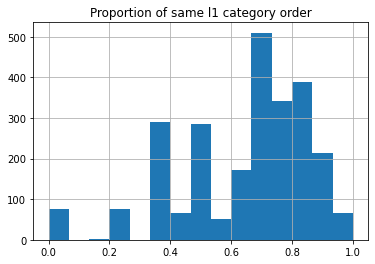

In [510]:
product_types['similarity'].hist(bins=15)
plt.title('Proportion of same l1 category order')

In [360]:
product_types['similarity'].describe()

count   2535.000000
mean       0.629015
std        0.216279
min        0.000000
25%        0.500000
50%        0.666667
75%        0.800000
max        1.000000
Name: similarity, dtype: float64

### 75% of the users' repeat purchase are related in terms of l1 category

In [361]:
product_types['similarity_l2'] = product_types.apply(lambda x: 
                                (x['purchase_dt'] - x['l2_category_name'])/x['purchase_dt'],axis=1)

Text(0.5, 1.0, 'Proportion of same l2 category order')

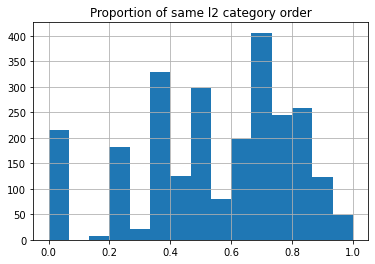

In [511]:
product_types['similarity_l2'].hist(bins=15)
plt.title('Proportion of same l2 category order')

In [363]:
product_types['similarity_l2'].describe()

count   2535.000000
mean       0.535132
std        0.253679
min        0.000000
25%        0.333333
50%        0.600000
75%        0.750000
max        1.000000
Name: similarity_l2, dtype: float64

### Breaking down to l2 category, still 50% of the users' purchase are related

## Taking cart reminders groups for example, analyze why v3 has higher AOV than v1

In [382]:
q = '''
with raw as (
--v1: control
  (select 'control' as user_group
    ,b1.user_id
    ,b1.campaign_uuid
    ,min(b1.dt) first_email_dt
    ,max(b1.dt) last_email_dt
    ,sum(case when lower(b2.bsft_link_url) like '%optout%' then 1 else 0 end) as unsub
from bls.blueshift_events b1
    left join bls.blueshift_events b2
        on b1.user_id = b2.user_id
            and b1.campaign_uuid = b2.campaign_uuid
            and b1.campaign_name = b2.campaign_name
where b1.dt between '2021-11-08' and '2021-11-22'
  and lower(b1.campaign_name) like '%cart%' 
  and lower(b1.campaign_name) like '%v1%'
  and (b1.event_name = 'Email Delivered' or b1.event_name = 'Push Notification Delivered')
group by 1,2,3
  )
--v3: treatment1
union all
(select 'treatment2' as user_group
    ,b1.user_id
    ,b1.campaign_uuid
    ,min(b1.dt) first_email_dt
    ,max(b1.dt) last_email_dt
    ,sum(case when lower(b2.bsft_link_url) like '%optout%' then 1 else 0 end) as unsub
from bls.blueshift_events b1
    left join bls.blueshift_events b2
        on b1.user_id = b2.user_id
            and b1.campaign_uuid = b2.campaign_uuid
            and b1.campaign_name = b2.campaign_name
where b1.dt between '2021-11-08' and '2021-11-22'
  and lower(b1.campaign_name) like '%cart%' 
  and lower(b1.campaign_name) like '%v3%'
  and (b1.event_name = 'Email Delivered' or b1.event_name = 'Push Notification Delivered')
group by 1,2,3
)
), preprocess as(
  select r1.*, r2.first_email_dt as next_email_dt
  from raw r1
    left join raw r2
      on r1.user_id = r2.user_id 
        and r1.campaign_uuid != r2.campaign_uuid
        and date_diff('day',date(r1.last_email_dt),date(r2.first_email_dt)) between 0 and 7
), processed as(
  select *
    , case when next_email_dt is null then cast(date(last_email_dt) + interval '7' day as varchar)
      else cast(last_email_dt as varchar) end as attributed_last_day
  from preprocess
)
select user_group
    ,b.user_id
    ,b.first_email_dt
    ,m.created
    ,m.order_id
    ,json_extract(l.action_metadata , '$.uprice') atc_price
    ,m.product_price
    ,m.shipping
    ,case when cast(json_extract(l.action_metadata , '$.vlid') as int) = m.item_id then 'abandoned_products'
        else 'other_products' end as purchase_type
    , s_xo.l1_category_name xo_l1
    , s_xo.l2_category_name xo_l2
    , s_xo.l3_category_name xo_l3
    , s_atc.l1_category_name atc_l1
    , s_atc.l2_category_name atc_l2
    , s_atc.l3_category_name atc_l3
from processed b
    inner join mp.order_item_margins_with_replacement m
        on b.user_id = cast(m.user_id as varchar)
            and b.first_email_dt <= substring(m.created,1,10)
            and b.attributed_last_day >= substring(m.created,1,10)
            and status in (0, 1, 2, 3, 4, 5, 20, 99)
            and is_replacement_order = 0
            and created >= '2021-11-08'
    inner join l2.user_action l
        on m.visitor_id = l.visitor_id
            and b.first_email_dt = l.dt
            and l.action = 'CART_ADD'
    inner join shop.vl_pupil s_xo
        on m.item_id = s_xo.vendor_listing_id
    inner join shop.vl_pupil s_atc
        on cast(json_extract(l.action_metadata , '$.vlid') as int) = s_atc.vendor_listing_id
where l.dt >= '2021-11-08'
'''

In [383]:
%%time
higher_aov = pd.read_sql_query(q, conn)

higher_aov

CPU times: user 187 ms, sys: 69.1 ms, total: 256 ms
Wall time: 36.9 s


,user_group,user_id,first_email_dt,created,order_id,atc_price,purchaed_products,product_price,shipping,purchase_type,xo_l1,xo_l2,xo_l3,atc_l1,atc_l2,atc_l3
0,control,3871203,2021-11-13,2021-11-21 06:28:49.0,1717048368563702,"""380.16""",111857885,90.000000,0.000000,other_products,lighting,outdoor lighting,outdoor wall lights and sconces,lighting,wall lighting,bathroom vanity lighting
1,control,3871203,2021-11-13,2021-11-21 06:28:49.0,1717048368563702,"""380.16""",111857885,90.000000,0.000000,other_products,lighting,outdoor lighting,outdoor wall lights and sconces,lighting,wall lighting,bathroom vanity lighting
2,control,3871203,2021-11-13,2021-11-21 06:28:49.0,1717048368563702,"""380.16""",111857885,90.000000,0.000000,other_products,lighting,outdoor lighting,outdoor wall lights and sconces,lighting,wall lighting,bathroom vanity lighting
3,control,3871203,2021-11-13,2021-11-21 06:28:49.0,1717048368563702,"""380.16""",111857885,90.000000,0.000000,other_products,lighting,outdoor lighting,outdoor wall lights and sconces,lighting,wall lighting,bathroom vanity lighting
4,control,3871203,2021-11-13,2021-11-21 06:28:49.0,1717048368563702,"""380.16""",111857885,90.000000,0.000000,other_products,lighting,outdoor lighting,outdoor wall lights and sconces,lighting,wall lighting,bathroom vanity lighting
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8973,control,12284261,2021-11-19,2021-11-19 13:24:28.0,1716893325409521,"""179.00""",116141984,92.520000,0.000000,other_products,outdoor products,outdoor decor,outdoor cushions and pillows,home decor,artwork,mixed media art
8974,control,12284261,2021-11-19,2021-11-19 13:24:28.0,1716893325409521,"""460.42""",116141984,92.520000,0.000000,other_products,outdoor products,outdoor decor,outdoor cushions and pillows,outdoor products,patio furniture and outdoor furniture,outdoor lounge furniture
8975,control,12284261,2021-11-19,2021-11-23 06:33:41.0,1717229869074389,"""179.00""",41829857,352.000000,0.000000,other_products,outdoor products,patio furniture and outdoor furniture,outdoor benches,home decor,artwork,mixed media art
8976,control,12284261,2021-11-19,2021-11-23 06:33:41.0,1717229869074389,"""460.42""",41829857,352.000000,0.000000,other_products,outdoor products,patio furniture and outdoor furniture,outdoor benches,outdoor products,patio furniture and outdoor furniture,outdoor lounge furniture


In [384]:
higher_aov['atc_price'] = higher_aov['atc_price'].apply(lambda x: float(x[1:-1]))

In [385]:
higher_aov.drop_duplicates(inplace=True)

In [386]:
higher_aov['price_diff'] = higher_aov.apply(lambda x: x['product_price'] - x['atc_price'], axis=1)

In [391]:
higher_aov[higher_aov['purchase_type']=='other_products'].groupby('user_group').describe()['atc_price']

,count,mean,std,min,25%,50%,75%,max
user_group,,,,,,,,
control,2788.000000,282.733034,401.614256,1.000000,54.000000,147.000000,335.250000,4896.000000
treatment2,2057.000000,308.433670,504.982154,0.690000,67.000000,134.000000,309.000000,5624.000000


In [392]:
higher_aov[higher_aov['purchase_type']=='other_products'].groupby('user_group').describe()['product_price']

,count,mean,std,min,25%,50%,75%,max
user_group,,,,,,,,
control,2788.000000,220.543694,328.426473,1.830000,47.000000,110.000000,255.000000,4403.000000
treatment2,2057.000000,308.929883,540.154297,0.690000,50.900000,132.000000,269.000000,6042.000000


In [394]:
higher_aov_others = higher_aov[higher_aov['purchase_type']=='other_products']

In [400]:
higher_aov[higher_aov['user_group']=='control']['atc_l1'].value_counts()[:5]

home decor          1319
lighting             590
furniture            408
bath products        341
home improvement     150
Name: atc_l1, dtype: int64

In [401]:
higher_aov[higher_aov['user_group']!='control']['atc_l1'].value_counts()[:5]

lighting            666
home decor          532
furniture           506
bath products       316
home improvement    163
Name: atc_l1, dtype: int64

In [402]:
higher_aov.groupby('atc_l1')[['atc_price']].describe()

atc_price                                  \
                               count       mean        std       min   
atc_l1                                                                 
baby and kids               5.000000  12.000000   6.708204  9.000000   
bath products             657.000000 544.142329 593.309536 10.900000   
bedroom products           69.000000 124.396812  72.454712 30.000000   
fabric                      7.000000  23.182857  10.224671  9.930000   
furniture                 914.000000 599.567155 704.747301 41.000000   
home decor               1851.000000 179.056650 254.075695 12.980000   
home improvement          313.000000 114.850288 296.745822  0.690000   
home office accessories    40.000000 545.188750 134.777022 47.000000   
housekeeping               26.000000  58.490385  49.312105  7.990000   
kitchen products          245.000000 242.251755 381.690900  7.000000   
lifestyle and leisure       8.000000 113.980000  44.318080 41.000000   
lighting                 1256.000000 260.201791 323.400532 19.000000   
outdoor products           93.000000 381.581075 549.865019 28.890000   
storage and organization   38.000000 176.718684 122.092789 42.000000   
tabletop                  125.000000  39.975440  22.385635 14.040000   
window treatments          70.000000  67.317143  79.203710 12.990000   

                                                                       
                                25%        50%        75%         max  
atc_l1                                                                 
baby and kids              9.000000   9.000000   9.000000   24.000000  
bath products             78.990000 272.000000 875.000000 3450.000000  
bedroom products          60.000000 126.000000 158.890000  299.000000  
fabric                    15.690000  23.000000  30.990000   35.990000  
furniture                190.435000 352.755000 753.677500 5624.000000  
home decor                48.290000  90.000000 202.310000 2999.000000  
home improvement           6.950000  15.000000  72.560000 1939.970000  
home office accessories  583.000000 583.000000 583.000000  583.000000  
housekeeping              37.250000  47.000000  47.000000  192.390000  
kitchen products          39.000000 175.000000 226.000000 2532.000000  
lifestyle and leisure     96.500000 104.500000 137.955000  173.940000  
lighting                 102.000000 154.000000 277.990000 4615.000000  
outdoor products          54.000000 249.000000 460.420000 4225.990000  
storage and organization  84.247500 135.720000 253.292500  469.000000  
tabletop                  37.000000  38.000000  39.000000  164.000000  
window treatments         29.990000  54.990000  79.000000  506.680000

In [396]:
higher_aov_others[higher_aov_others['user_group']=='control']['atc_l1'].value_counts()[:5]

home decor          1198
lighting             514
furniture            311
bath products        270
kitchen products     120
Name: atc_l1, dtype: int64

In [397]:
higher_aov_others[higher_aov_others['user_group']=='control']['xo_l1'].value_counts()[:5]

home decor          1214
lighting             472
furniture            299
bath products        275
kitchen products     156
Name: xo_l1, dtype: int64

In [398]:
higher_aov_others[higher_aov_others['user_group']=='treatment2']['atc_l1'].value_counts()[:5]

lighting            588
home decor          439
furniture           398
bath products       253
home improvement    112
Name: atc_l1, dtype: int64

In [399]:
higher_aov_others[higher_aov_others['user_group']=='treatment2']['xo_l1'].value_counts()[:5]

lighting            496
furniture           423
home decor          416
bath products       255
home improvement    160
Name: xo_l1, dtype: int64

In [405]:
higher_aov_others[(higher_aov_others['user_group']=='treatment2')&(higher_aov_others['xo_l1']=='furniture')]['atc_l1'].value_counts()[:10]

furniture            213
lighting              83
home decor            66
bath products         19
kitchen products       6
outdoor products       6
home improvement       6
window treatments      6
tabletop               4
housekeeping           4
Name: atc_l1, dtype: int64

In [406]:
higher_aov_others[(higher_aov_others['user_group']=='treatment2')&(higher_aov_others['xo_l1']=='furniture')]['atc_l2'].value_counts()[:10]

living room furniture                  109
lamps                                   64
kitchen and dining furniture            43
bedroom furniture                       28
rugs                                    26
decorative accents                      22
home office furniture                   18
ceiling lighting                        13
wall decor                               9
bathroom vanities and sink consoles      9
Name: atc_l2, dtype: int64

In [407]:
higher_aov_others[(higher_aov_others['user_group']=='treatment2')&(higher_aov_others['xo_l1']=='furniture')]['xo_l2'].value_counts()[:10]

living room furniture           168
bedroom furniture               104
kitchen and dining furniture     56
home office furniture            48
indoor benches                   23
media storage                    17
game room and bar furniture       6
bookcases                         1
Name: xo_l2, dtype: int64

In [408]:
higher_aov_others[(higher_aov_others['user_group']=='treatment2')&(higher_aov_others['xo_l1']=='furniture')]['atc_l3'].value_counts()[:10]

coffee and accent tables          72
floor lamps                       50
living room chairs                23
area rugs                         21
dining chairs                     19
bar stools and counter stools     13
nightstands and bedside tables    12
desks and hutches                 12
beds                              11
sofas and sectionals              11
Name: atc_l3, dtype: int64

In [409]:
higher_aov_others[(higher_aov_others['user_group']=='treatment2')&(higher_aov_others['xo_l1']=='furniture')]['xo_l3'].value_counts()[:10]

coffee and accent tables          79
footstools and ottomans           39
living room chairs                36
nightstands and bedside tables    34
beds                              30
desks and hutches                 28
bar stools and counter stools     22
dining chairs                     18
dressers                          17
accent and storage benches        15
Name: xo_l3, dtype: int64

In [412]:
higher_aov_others[(higher_aov_others['user_group']=='treatment2')&(higher_aov_others['atc_l3']=='floor lamps')]['xo_l3'].value_counts()

floor lamps                       22
table lamps                       18
nightstands and bedside tables    11
area rugs                          8
decorative pillows                 6
swing arm wall lamps               5
accent and storage benches         5
beds                               5
living room chairs                 5
dressers                           5
jewelry armoires                   5
coffee and accent tables           5
footstools and ottomans            5
mattresses                         3
cabinet and drawer hardware        2
table tops and bases               1
Name: xo_l3, dtype: int64

### Out of those active on MPL, how many are active outside of MPL? 
    - Do they actively browse photos/read articles? (add product to ideabook)
        - Among 14 day active users, 66% of them have account more than one year. And they are comparatively active on outside of MPL.
    - How can non-MPL Houzz pages drive purchases? 
        - 
    
* For those loyal customers, how their consumer behavior relate to their purchase

In [472]:
q = '''
with active_users as(
select user_id
from l2.session_analytics
where dt between '2021-11-09' and '2021-11-23'
group by user_id
having sum(browse_products + cart_add + checkout_billing_and_payment + checkout_launch + checkout_shipping +
            checkout_order_review + checkout_order_confirmation + view_cart + view_product + cart_remove) > 0
), account_info as(
select c.user_id
from c2.users c
    inner join active_users a
        on c.user_id = a.user_id
where c.created <= '2020-12-31'
)

select a.user_id
    , count(distinct session_id) sessions
    , sum(add_to_ideabook) add_to_ideabook
    , sum(browse_photos) browse_photos
    , sum(browse_products) browse_products
    , sum(browse_discussions) browse_discussions
    , sum(browse_professionals) browse_professionals
    , sum(browse_ideabooks) browse_ideabooks
    , sum(cart_add) cart_add
    , sum(checkout_billing_and_payment) checkout_billing_and_payment
    , sum(checkout_launch) checkout_launch
    , sum(checkout_shipping) checkout_shipping
    , sum(checkout_order_review) checkout_order_review
    , sum(checkout_order_confirmation) checkout_order_confirmation
    , sum(view_cart) view_cart
    , sum(view_photo) view_photo
    , sum(view_product) view_product
    , sum(view_discussion) view_discussion
    , sum(browse_user_reviews) browse_user_reviews
    , sum(browse_user_photos) browse_user_photos
    , sum(browse_user_ideabooks) browse_user_ideabooks
    , sum(view_project) view_project
    , sum(search_photos) search_photos
    , sum(search_products) search_products
    , sum(add_product_to_ideabook) add_product_to_ideabook
from account_info a
    inner join mp.order_item_margins_with_replacement m
        on a.user_id = m.user_id
            and status in (0, 1, 2, 3, 4, 5, 20, 99)
            and is_replacement_order = 0
    left join l2.session_analytics l
        on l.user_id = a.user_id
            and l.dt between '2021-11-05' and '2021-11-23'
            and date_diff('day',date(l.dt) ,date(substring(m.created,1,10))) between 0 and 7
where created between '2021-11-08' and '2021-11-23'
group by 1

'''

In [473]:
%%time
conversion = pd.read_sql_query(q, conn)

conversion

CPU times: user 175 ms, sys: 117 ms, total: 292 ms
Wall time: 13.6 s


,user_id,sessions,add_to_ideabook,browse_photos,browse_products,browse_discussions,browse_professionals,browse_ideabooks,cart_add,checkout_billing_and_payment,checkout_launch,checkout_shipping,checkout_order_review,checkout_order_confirmation,view_cart,view_photo,view_product,view_discussion,browse_user_reviews,browse_user_photos,browse_user_ideabooks,view_project,search_photos,search_products,add_product_to_ideabook
0,53558093,2,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,4807538,3,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2320943,16,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,2.000000,2.000000,6.000000,1.000000,11.000000,1.000000,6.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000
3,62890961,53,841.000000,6.000000,2164.000000,0.000000,22.000000,0.000000,182.000000,0.000000,0.000000,0.000000,0.000000,0.000000,66.000000,0.000000,1938.000000,0.000000,0.000000,0.000000,342.000000,0.000000,0.000000,542.000000,841.000000
4,47886965,20,1.000000,1.000000,38.000000,0.000000,0.000000,1.000000,22.000000,20.000000,50.000000,41.000000,49.000000,19.000000,94.000000,0.000000,117.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15493,40325258,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,2.000000,9.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15494,56886003,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15495,32161271,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15496,2450486,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [474]:
conversion.describe()

,user_id,sessions,add_to_ideabook,browse_photos,browse_products,browse_discussions,browse_professionals,browse_ideabooks,cart_add,checkout_billing_and_payment,checkout_launch,checkout_shipping,checkout_order_review,checkout_order_confirmation,view_cart,view_photo,view_product,view_discussion,browse_user_reviews,browse_user_photos,browse_user_ideabooks,view_project,search_photos,search_products,add_product_to_ideabook
count,15498.000000,15498.000000,15426.000000,15426.000000,15426.000000,15426.000000,15426.000000,15426.000000,15426.000000,15426.000000,15426.000000,15426.000000,15426.000000,15426.000000,15426.000000,15426.000000,15426.000000,15426.000000,15426.000000,15426.000000,15426.000000,15426.000000,15426.000000,15426.000000,15426.000000
mean,30729755.788360,3.212673,1.741086,3.264294,21.832815,0.082782,0.118761,0.172177,4.818359,2.065474,4.550110,2.878387,6.188643,2.802023,7.051666,1.117010,25.111500,0.263905,0.010307,0.011798,0.436860,0.110074,1.891676,6.816543,1.369571
std,20589739.475236,4.685523,72.955959,35.759756,141.257861,3.602532,3.920130,14.885139,39.448022,8.085395,16.921732,11.813779,25.539141,14.349184,52.220965,18.191148,179.352732,7.258785,0.371371,0.470032,23.624920,2.272392,21.896376,59.137038,71.457835
min,5357.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11100037.250000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,30452708.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,49323703.000000,3.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,2.000000,2.000000,4.000000,3.000000,4.000000,2.000000,4.000000,0.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,65953926.000000,140.000000,8751.000000,2900.000000,12003.000000,327.000000,440.000000,1846.000000,3447.000000,600.000000,928.000000,1000.000000,1200.000000,1128.000000,4450.000000,1142.000000,16810.000000,750.000000,32.000000,44.000000,2829.000000,213.000000,1740.000000,4422.000000,8751.000000


In [428]:
## If their purchased products are already in cart

q = '''
with active_users as(
select user_id
from l2.session_analytics
where dt between '2021-11-09' and '2021-11-23'
group by user_id
having sum(browse_products + cart_add + checkout_billing_and_payment + checkout_launch + checkout_shipping +
            checkout_order_review + checkout_order_confirmation + view_cart + view_product + cart_remove) > 0
), account_info as(
select c.user_id
from c2.users c
    inner join active_users a
        on c.user_id = a.user_id
where c.created <= '2020-12-31'
)

select a.user_id
    ,m.created
    ,l.dt
from account_info a
    inner join mp.order_item_margins_with_replacement m
        on a.user_id = m.user_id
            and status in (0, 1, 2, 3, 4, 5, 20, 99)
            and is_replacement_order = 0
    inner join l2.user_action l
        on m.visitor_id = l.visitor_id
            and l.dt between '2021-01-01' and '2021-11-23'
            and l.dt <= substring(m.created, 1, 10)
            and l.action = 'CART_ADD'
            and cast(json_extract(l.action_metadata , '$.vlid') as int) = m.item_id
where created between '2021-11-08' and '2021-11-23'
'''

In [429]:
%%time
atc_time = pd.read_sql_query(q, conn)

atc_time

CPU times: user 182 ms, sys: 93.9 ms, total: 276 ms
Wall time: 1min 27s


,user_id,created,dt
0,27136918,2021-11-14 06:14:38.0,2021-11-13
1,27136918,2021-11-14 06:14:38.0,2021-11-13
2,27143317,2021-11-09 09:49:18.0,2021-11-09
3,27177186,2021-11-18 11:58:18.0,2021-11-17
4,27177334,2021-11-19 14:35:02.0,2021-11-19
...,...,...,...
29580,55924506,2021-11-13 11:46:12.0,2021-11-13
29581,55924506,2021-11-13 11:46:12.0,2021-11-06
29582,55924506,2021-11-13 11:46:12.0,2021-11-13
29583,22572591,2021-11-10 06:51:44.0,2021-11-10


In [431]:
atc_time.drop_duplicates(inplace=True)

In [432]:
atc_time.shape

(13370, 3)

In [433]:
atc_time[atc_time['dt']<='2021-11-08']

,user_id,created,dt
37,4535813,2021-11-09 09:20:17.0,2021-11-05
81,28497383,2021-11-10 05:23:42.0,2021-11-08
97,29026898,2021-11-18 15:50:34.0,2021-11-01
98,50676685,2021-11-08 10:09:35.0,2021-11-08
107,51600210,2021-11-08 11:27:13.0,2021-11-02
...,...,...,...
29542,64205685,2021-11-12 20:23:36.0,2021-11-04
29547,41975813,2021-11-13 12:47:43.0,2021-11-05
29554,12674355,2021-11-08 14:23:57.0,2021-11-08
29566,36247006,2021-11-09 17:29:01.0,2021-11-08


### What emails they open the most (But not unsubscribe)?

In [367]:
result[(result['opens']>0)&(result['unsubs']==0)]['campaign_name'].value_counts()[:20]

newsletter_editorial_v1                       166159
trending-room-photo-email                      61214
community-interest-photo-email                 59787
community-interest-photo-email2                47064
community-project-email                        45438
interest-story-email                           45225
order_confirmation_email_us                    23238
11212021 - Shop Houzz - Email                  18549
order_shipped_email_us                         18129
11182021 - Shop Houzz - Email                  17362
11232021 - Shop Houzz - Email                  15343
order_out_for_delivery_email_us                14067
order_delivered_email_us                       13228
11142021 - Shop Houzz - Email                  11721
11112021 NEW - Shop Houzz - Email              10548
11092021 - Shop Houzz - Email                   8593
Cart Reminder - V3 - Email                      6626
MagicLinkEmail                                  6235
Related Products/People Also Liked - Email    

In [369]:
from collections import Counter

text = ' '.join(result[(result['opens']>0)&(result['unsubs']==0)]['campaign_name'].tolist())
campaigns = text.replace('-',' ').replace('_',' ').split(' ')
all_campaigns = ' '.join(campaigns)
words = all_campaigns.split()

# words wrong datatype
counts = Counter(words)

In [370]:
counts.most_common(20)

[('email', 295498),
 ('photo', 168065),
 ('newsletter', 166159),
 ('editorial', 166159),
 ('v1', 166159),
 ('community', 152289),
 ('interest', 152076),
 ('Email', 139626),
 ('Houzz', 92679),
 ('Shop', 92115),
 ('order', 69058),
 ('us', 68674),
 ('trending', 61214),
 ('room', 61214),
 ('email2', 47064),
 ('project', 45438),
 ('story', 45225),
 ('confirmation', 23238),
 ('11212021', 20217),
 ('11182021', 20190)]

In [372]:
result[result['campaign_name'].str.contains('photo')]['campaign_name'].value_counts()

trending-room-photo-email          164789
community-interest-photo-email     154849
community-interest-photo-email2    130821
community-interest-photo-push       29609
ads-photos-approval-email              68
Name: campaign_name, dtype: int64

In [373]:
result[result['campaign_name'].str.contains('newsletter')]['campaign_name'].value_counts()

newsletter_editorial_v1    506415
Name: campaign_name, dtype: int64

In [375]:
result[result['campaign_name'].str.contains('Shop Houzz')]['campaign_name'].value_counts()

11112021 NEW - Shop Houzz - Email     86643
11212021 - Shop Houzz - Email         85411
11232021 - Shop Houzz - Email         84278
11182021 - Shop Houzz - Email         75374
11142021 - Shop Houzz - Email         57080
11092021 - Shop Houzz - Email         37615
11082021 - Shop Houzz - Email         36268
11142021 - Shop Houzz - LC - Email    25607
11182021 - Shop Houzz - LC - Email    17672
11212021 - Shop Houzz - LC - Email    12257
11112021 NEW - Shop Houzz - Push       6756
11232021 - Shop Houzz - Push           5583
11212021 - Shop Houzz - Push           5456
11182021 - Shop Houzz - Push           5120
11142021 - Shop Houzz - Push           4506
11092021 - Shop Houzz - Push           3350
11232021 - Shop Houzz - LC - Email     3108
11142021 - Shop Houzz - LC - Push      1584
11182021 - Shop Houzz - LC - Push       972
11212021 - Shop Houzz - LC - Push       579
11232021 - Shop Houzz - LC - Push       225
11082021 - Shop Houzz - Push             24
Name: campaign_name, dtype: int6

In [376]:
result[result['campaign_name'].str.contains('order')]['campaign_name'].value_counts()

order_confirmation_email_us          32936
order_shipped_email_us               26855
order_delivered_email_us             22794
order_out_for_delivery_email_us      22689
order_freight_schedule_appt_email      541
Name: campaign_name, dtype: int64

In [380]:
result[result['campaign_name'].str.contains('project')]['campaign_name'].value_counts()

community-project-email    140205
community-project-push       9278
Name: campaign_name, dtype: int64

In [381]:
result[result['campaign_name'].str.contains('story')]['campaign_name'].value_counts()

interest-story-email    115106
Name: campaign_name, dtype: int64

### Further study on loyal customers (Those with account more than 1 year)

- Average Churn rate of first year customers
- How those loyal customers stay or different from churned customers

In [437]:
q = '''
with active_users as(
select user_id
from l2.session_analytics
where dt between '2020-01-01' and '2020-12-31'
group by user_id
having sum(browse_products + cart_add + checkout_billing_and_payment + checkout_launch + checkout_shipping +
            checkout_order_review + checkout_order_confirmation + view_cart + view_product + cart_remove) > 0
)
select count(distinct c.user_id) users
from c2.users c
    inner join active_users a
        on c.user_id = a.user_id
where c.created between '2020-01-01' and '2020-12-31'

'''

In [438]:
%%time
mpl_active_user_2020 = pd.read_sql_query(q, conn)

mpl_active_user_2020

CPU times: user 55.5 ms, sys: 13.7 ms, total: 69.2 ms
Wall time: 34.1 s


,users
0,1495149


In [ ]:
q = '''
with active_users as(
select user_id
from l2.session_analytics
where dt between '2020-01-01' and '2020-12-31'
group by user_id
having sum(browse_products + cart_add + checkout_billing_and_payment + checkout_launch + checkout_shipping +
            checkout_order_review + checkout_order_confirmation + view_cart + view_product + cart_remove) > 0
), account as(
select c.user_id
from c2.users c
    inner join active_users a
        on c.user_id = a.user_id
where c.created between '2020-01-01' and '2020-12-31'
)

select user_id
from account a
    inner join l2.session_analytics l
        on a.user_id = l.user_id
where l.dt between '2021-01-01' and '2021-12-31'
group by a.user_id
having sum(browse_products + cart_add + checkout_billing_and_payment + checkout_launch + checkout_shipping +
            checkout_order_review + checkout_order_confirmation + view_cart + view_product + cart_remove) > 0
'''

In [445]:
249840/1495149

0.16710040270233936

In [457]:
q = '''
select s.user_id
from shiying.active_mpl_users_2020_to_2021 s
    inner join l2.session_analytics l
        on s.user_id = l.user_id
where l.dt between '2020-01-01' and '2020-12-31'
group by s.user_id
having sum(add_to_ideabook+ browse_photos+ browse_discussions + browse_professionals+
       browse_ideabooks+view_photo+view_discussion+browse_user_reviews+browse_user_photos+browse_user_ideabooks
       +view_project+search_photos+add_product_to_ideabook) > 5
'''

In [458]:
%%time
mpl_active_user_2020_to_2021 = pd.read_sql_query(q, conn)

mpl_active_user_2020_to_2021

CPU times: user 598 ms, sys: 112 ms, total: 710 ms
Wall time: 1min 30s


,user_id
0,59850209
1,59850901
2,59851582
3,59851780
4,59851864
...,...
130663,64939069
130664,64939476
130665,64945218
130666,64945897


In [459]:
130668/249840

0.5230067243035543

### If those repurchase in 14 days after first order have higher LTV?

In [477]:
q = '''
with repeat_purchaser as(
select l1.user_id
from logs.marketplace_valid_orders_detailed_daily l1
    inner join logs.marketplace_valid_orders_detailed_daily l2
        on l1.user_id = l2.user_id
            and date_diff('day',date(substring(l1.created, 1, 10)),date(substring(l2.created, 1, 10))) between 0 and 14
where l1.created between '2020-11-01' and '2020-12-31'
    and l1.checkout_type = 'FIRST_UNCANCELLED_CHECKOUT'
    and l2.created between '2020-11-01' and '2021-12-31' 
    and l2.checkout_type = 'REPEAT_CHECKOUT'
)

select count(distinct r.user_id) repeat_purchasers
    , count(distinct m.user_id) remained_purchaser
    , avg(product_price) aov
    , sum(product_price) total_gmv
from repeat_purchaser r
left join mp.order_item_margins_with_replacement m
        on r.user_id = m.user_id
            and status in (0, 1, 2, 3, 4, 5, 20, 99)
            and is_replacement_order = 0
            and m.created >= '2021-01-01'
    
'''

In [478]:
%%time
repeat_users_ltv = pd.read_sql_query(q, conn)

repeat_users_ltv

CPU times: user 14.2 ms, sys: 5.11 ms, total: 19.3 ms
Wall time: 3.43 s


,repeat_purchasers,remained_purchaser,aov,total_gmv
0,4348,1148,124.821293,4800002.840000


In [479]:
1148/4348

0.2640294388224471

In [492]:
q = '''
with repeat_purchaser as(
select l1.visitor_id
from mp.order_item_margins_with_replacement l1
    inner join mp.order_item_margins_with_replacement l2
        on l1.user_id = l2.user_id
            and date_diff('day',date(substring(l1.created, 1, 10)),date(substring(l2.created, 1, 10))) between 0 and 14
where l1.created between '2020-11-01' and '2020-12-31'
    and l1.checkout_type = 'FIRST_UNCANCELLED_CHECKOUT'
    and l2.created between '2020-11-01' and '2021-12-31' 
    and l2.checkout_type = 'REPEAT_CHECKOUT'
)

select r.visitor_id
from repeat_purchaser r
left join l2.session_analytics l
        on r.visitor_id = l.visitor_id
            and l.dt >= '2021-01-01'
group by r.visitor_id
having sum(browse_products + cart_add + checkout_billing_and_payment + checkout_launch + checkout_shipping +
            checkout_order_review + checkout_order_confirmation + view_cart + view_product + cart_remove) > 0
    
'''

In [493]:
%%time
repeat_users_retention = pd.read_sql_query(q, conn)

repeat_users_retention

CPU times: user 123 ms, sys: 45.9 ms, total: 168 ms
Wall time: 1min 8s


,visitor_id
0,8e28b483-3c90-4c37-9e3b-90ee9c328626
1,931d1076-b95d-4e05-a328-7fb6d82f92ba
2,70ba1c74-cb15-4ce2-a9ec-fb88f4314818
3,e42fd7dd-4b1c-4c67-8c80-0a9fe9ba49df
4,8f9e64e0-7205-422f-9653-75c73e5607b3
...,...
1774,8a1e5a6f-ac3c-4036-9fc0-dd7327cc50ea
1775,dede39c4-c48d-4f83-bc8c-5f0d03cd0456
1776,2c36fa98-4f70-4d8a-a9a5-e748c590034e
1777,2a4fd9ab-720b-4ecc-957f-a3434b69417f


In [494]:
1779/4348

0.4091536338546458

In [495]:
4800002.840000/124.821293

38455.000141682554

In [496]:
38455.000141682554/1148

33.49738688299874

In [549]:
q = '''
select user_id
from l2.session_analytics
where dt between '2021-11-09' and '2021-11-23'
group by user_id
having sum(browse_products + cart_add + checkout_billing_and_payment + checkout_launch + checkout_shipping +
            checkout_order_review + checkout_order_confirmation + view_cart + view_product + cart_remove) > 0
'''

In [550]:
%%time
checking = pd.read_sql_query(q, conn)

checking

CPU times: user 948 ms, sys: 1.92 s, total: 2.87 s
Wall time: 15.8 s


,user_id
0,5419733.000000
1,6436049.000000
2,8000883.000000
3,22522763.000000
4,24372995.000000
...,...
268442,2860452.000000
268443,9571945.000000
268444,57909195.000000
268445,68894420.000000


In [551]:
q = '''
select user_id
from l2.session_analytics
where dt between '2021-11-09' and '2021-11-23'
group by user_id
having sum(browse_products + cart_add + checkout_billing_and_payment + checkout_launch + checkout_shipping +
            checkout_order_review + checkout_order_confirmation + view_cart + view_product + cart_remove) > 0
    and sum(add_to_ideabook+ browse_photos+ browse_discussions + browse_professionals+
       browse_ideabooks+view_photo+view_discussion+browse_user_reviews+browse_user_photos+browse_user_ideabooks
       +view_project+search_photos+add_product_to_ideabook) > 0
'''

In [552]:
%%time
checking = pd.read_sql_query(q, conn)

checking

CPU times: user 329 ms, sys: 14.1 ms, total: 343 ms
Wall time: 10.4 s


,user_id
0,7281680.000000
1,10957543.000000
2,13822377.000000
3,15829931.000000
4,16296845.000000
...,...
113401,69492451.000000
113402,52263839.000000
113403,7932903.000000
113404,67104030.000000


In [553]:
113406/268447

0.4224521041397371

In [564]:
q = '''
with active_users as(
select user_id
    ,case when sum(checkout_order_confirmation) > 0 then 'xo_users'
        else 'active_wo_xo' end user_type
from l2.session_analytics
where dt between '2021-11-09' and '2021-11-23'
group by user_id
having sum(browse_products + cart_add + checkout_billing_and_payment + checkout_launch + checkout_shipping +
            checkout_order_review + checkout_order_confirmation + view_cart + view_product + cart_remove) > 0
)

select b.user_id
    , b.campaign_name
    , user_type
    , b.dt
    , case when count(b1.event_id) > 0 then 1 else 0 end opens
    , case when count(b2.event_id) > 0 then 1 else 0 end clicks
    , case when count(b3.event_id) > 0 then 1 else 0 end unsubs
from bls.blueshift_events b
    inner join active_users a
        on b.user_id = cast(a.user_id as varchar)
    left join bls.blueshift_events b1
        on b.user_id = b1.user_id
            and b.campaign_name = b1.campaign_name
            and b.dt <= b1.dt
            and lower(b1.event_name) like '%open%'
            and b1.dt between '2021-11-09' and '2021-11-23'
    left join bls.blueshift_events b2
        on b.user_id = b2.user_id
            and b.campaign_name = b2.campaign_name
            and b.dt <= b2.dt
            and lower(b2.event_name) like '%click%'
            and b2.dt between '2021-11-09' and '2021-11-23'
    left join bls.blueshift_events b3
        on b.user_id = b3.user_id
            and b.campaign_name = b3.campaign_name
            and b.dt <= b3.dt
            and b3.event_name = 'Email Link Clicked'
            and b3.dt between '2021-11-09' and '2021-11-23'
where b.dt between '2021-11-09' and '2021-11-23'
    and b.event_name in ('Email Delivered','Push Notification Sent')

group by 1,2,3,4

union all 


select cast(e.user_id as varchar)
    ,epn_name as campaign_name
    ,e.user_type
    ,e.dt
    ,sum(case when is_open > 0 then 1 else 0 end) as opens
    ,sum(case when is_click > 0 then 1 else 0 end) as clicks
    ,sum(case when is_unsub > 0 then 1 else 0 end) as unsubs

from 

(
select dt, send_id, b.user_id, epn_name, user_type
FROM l2.batch_epn_send b
inner join active_users a
        on b.user_id = a.user_id
where dt between '2021-11-09' and '2021-11-23'
and epn_name != 'silent-push'
and event_type = 'email_send'
and length(trim(fail_reason)) = 0

union all

select dt, send_id, b.user_id, epn_name, user_type
FROM l2.epn_send b
inner join active_users a
        on b.user_id = a.user_id
where dt between '2021-11-09' and '2021-11-23'
and epn_name != 'silent-push'
and event_type = 'email_send'
and length(trim(fail_reason)) = 0
) e

left join 
(
select distinct send_id, b.user_id, user_type,
if(event_type = 'nlpv', 1, 0) as is_open,
if(event_type in ('nllc','nlac'), 1, 0) as is_click, -- nllc is regular click, nlac is click on ad banner
if(event_type = 'en_optout', 1, 0) as is_unsub
--distinct actions per user per email
from l2.epn_send_action_daily b
inner join active_users a
        on b.user_id = a.user_id
where date(dt) between date('2021-11-09') and date_add('day',7,date('2021-11-23'))
and event_type in ('nlpv','nllc','nlac','en_optout')
and send_id is not NULL
) a

on e.send_id = a.send_id
group by 1,2,3,4
'''

In [565]:
%%time
open_behavior = pd.read_sql_query(q, conn)

open_behavior

CPU times: user 14 s, sys: 1.88 s, total: 15.9 s
Wall time: 6min 45s


,user_id,campaign_name,user_type,dt,opens,clicks,unsubs
0,3406467,11232021 - Shop Houzz - Email,active_wo_xo,2021-11-23,0,0,0
1,3462567,11212021 - Shop Houzz - Email,active_wo_xo,2021-11-23,0,0,0
2,17424696,11232021 - Shop Houzz - Push,active_wo_xo,2021-11-23,0,0,0
3,19645083,Cart Reminder - V2 - Email,active_wo_xo,2021-11-23,0,0,0
4,26843733,11232021 - Shop Houzz - Email,active_wo_xo,2021-11-23,1,0,0
...,...,...,...,...,...,...,...
2302075,70734875,welcome_email,active_wo_xo,2021-11-12,0,0,0
2302076,9809575,order_confirmation_email_us,xo_users,2021-11-12,1,0,0
2302077,3823231,order_confirmation_email_us,xo_users,2021-11-15,0,0,0
2302078,8922907,MagicLinkEmail,active_wo_xo,2021-11-15,1,0,0


In [578]:
open_behavior['mpl'] = 0
for i in mpl_email:
    open_behavior.loc[open_behavior['campaign_name'].str.lower().str.contains(i),'mpl'] = 1

In [590]:
open_behavior['mpl_open'] = 0
open_behavior.loc[(open_behavior['mpl']>0)&(open_behavior['opens']>0),'mpl_open'] = 1

In [615]:
open_behavior['consumer_open'] = 0
open_behavior.loc[(open_behavior['mpl']==0)&(open_behavior['opens']>0),'mpl_open'] = 1

In [616]:
open_behavior_summary = open_behavior.groupby(['user_id','user_type']).agg({
        'campaign_name':'count','opens':'sum','mpl':'sum','mpl_open':'sum','consumer_open':'sum'}).reset_index()

In [594]:
open_behavior_summary.groupby('user_type').describe().unstack(1)

                      user_type   
campaign_name  count  active_wo_xo   190956.000000
                      xo_users        31509.000000
               mean   active_wo_xo       10.540507
                      xo_users            9.181726
               std    active_wo_xo        7.320209
                                          ...     
mpl_open       50%    xo_users            0.000000
               75%    active_wo_xo        1.000000
                      xo_users            1.000000
               max    active_wo_xo       16.000000
                      xo_users           18.000000
Length: 64, dtype: float64

In [593]:
open_behavior_summary

,user_id,user_type,campaign_name,opens,mpl,mpl_open
0,10000104,active_wo_xo,6,0,1,0
1,10000320,active_wo_xo,23,0,4,0
2,10000604,active_wo_xo,17,14,4,2
3,10000944,active_wo_xo,11,0,6,0
4,10000989,active_wo_xo,20,6,6,1
...,...,...,...,...,...,...
222460,9997212,active_wo_xo,5,0,0,0
222461,9997261,active_wo_xo,8,0,3,0
222462,9998326,active_wo_xo,14,0,6,0
222463,9998696,active_wo_xo,7,2,4,1


In [573]:
open_behavior_summary[open_behavior_summary['opens']==0].groupby('user_type').agg({'user_id':pd.Series.nunique})

,user_id
user_type,
active_wo_xo,81491
xo_users,5561


In [574]:
open_behavior_summary[(open_behavior_summary['opens']>=1)
                      &(open_behavior_summary['opens']<=3)].groupby('user_type').agg({'user_id':pd.Series.nunique})

,user_id
user_type,
active_wo_xo,53560
xo_users,13829


In [575]:
open_behavior_summary[(open_behavior_summary['opens']>=4)
                      &(open_behavior_summary['opens']<=6)].groupby('user_type').agg({'user_id':pd.Series.nunique})

,user_id
user_type,
active_wo_xo,21870
xo_users,6659


In [576]:
open_behavior_summary[(open_behavior_summary['opens']>=7)
                      &(open_behavior_summary['opens']<=10)].groupby('user_type').agg({'user_id':pd.Series.nunique})

,user_id
user_type,
active_wo_xo,15132
xo_users,2845


In [582]:
open_behavior_summary[(open_behavior_summary['opens']>=11)].groupby('user_type').agg({'user_id':pd.Series.nunique})

,user_id
user_type,
active_wo_xo,18903
xo_users,2615


In [595]:
open_behavior_summary[open_behavior_summary['mpl_open']==0].groupby('user_type').agg({'user_id':pd.Series.nunique})

,user_id
user_type,
active_wo_xo,136589
xo_users,21837


In [596]:
open_behavior_summary[(open_behavior_summary['mpl_open']>=1)
                      &(open_behavior_summary['mpl_open']<=3)].groupby('user_type').agg({'user_id':pd.Series.nunique})

,user_id
user_type,
active_wo_xo,40700
xo_users,7319


In [597]:
open_behavior_summary[(open_behavior_summary['mpl_open']>=4)
                      &(open_behavior_summary['mpl_open']<=6)].groupby('user_type').agg({'user_id':pd.Series.nunique})

,user_id
user_type,
active_wo_xo,11697
xo_users,1848


In [598]:
open_behavior_summary[(open_behavior_summary['mpl_open']>=7)
                      &(open_behavior_summary['mpl_open']<=10)].groupby('user_type').agg({'user_id':pd.Series.nunique})

,user_id
user_type,
active_wo_xo,1818
xo_users,452


In [599]:
open_behavior_summary[(open_behavior_summary['mpl_open']>=11)].groupby('user_type').agg({'user_id':pd.Series.nunique})

,user_id
user_type,
active_wo_xo,152
xo_users,53


In [621]:
open_behavior_summary[open_behavior_summary['consumer_open']==0].groupby('user_type').agg({'user_id':pd.Series.nunique})

,user_id
user_type,
active_wo_xo,190956
xo_users,31509


In [620]:
open_behavior_summary[(open_behavior_summary['consumer_open']>=1)
            &(open_behavior_summary['consumer_open']<=3)].groupby('user_type').agg({'user_id':pd.Series.nunique})

,user_id
user_type,


In [622]:
open_behavior_summary[(open_behavior_summary['consumer_open']>=4)
            &(open_behavior_summary['consumer_open']<=6)].groupby('user_type').agg({'user_id':pd.Series.nunique})

,user_id
user_type,


In [623]:
open_behavior_summary[(open_behavior_summary['consumer_open']>=4)
            &(open_behavior_summary['consumer_open']<=6)].groupby('user_type').agg({'user_id':pd.Series.nunique})

,user_id
user_type,


In [617]:
open_behavior_summary[:3]

,user_id,user_type,campaign_name,opens,mpl,mpl_open,consumer_open
0,10000104,active_wo_xo,6,0,1,0,0
1,10000320,active_wo_xo,23,0,4,0,0
2,10000604,active_wo_xo,17,14,4,14,0


In [603]:
open_behavior_summary.loc[open_behavior_summary['mpl']==0,'mpl'] = 1

In [604]:
open_behavior_summary['email_opened_rate'] = open_behavior_summary.apply(lambda x: x['opens']/x['campaign_name'],axis=1)
open_behavior_summary['mpl_email_opened_rate'] = open_behavior_summary.apply(lambda x: x['mpl_open']/x['mpl'],axis=1)

In [607]:
open_behavior_summary = open_behavior_summary[open_behavior_summary['email_opened_rate']<=1]
open_behavior_summary = open_behavior_summary[open_behavior_summary['mpl_email_opened_rate']<=1]

<AxesSubplot:>

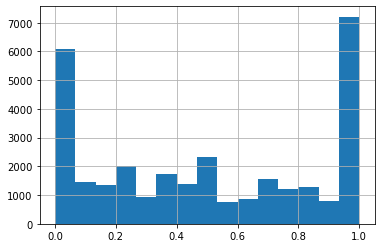

In [610]:
open_behavior_summary[open_behavior_summary['user_type']=='xo_users']['email_opened_rate'].hist(bins=15)

<AxesSubplot:>

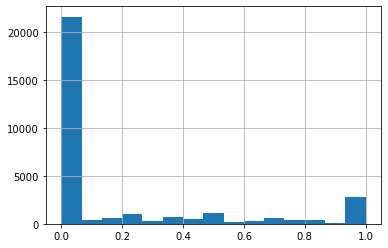

In [612]:
open_behavior_summary[open_behavior_summary['user_type']=='xo_users']['mpl_email_opened_rate'].hist(bins=15)

<AxesSubplot:>

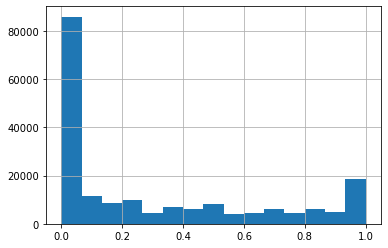

In [613]:
open_behavior_summary[open_behavior_summary['user_type']!='xo_users']['email_opened_rate'].hist(bins=15)

<AxesSubplot:>

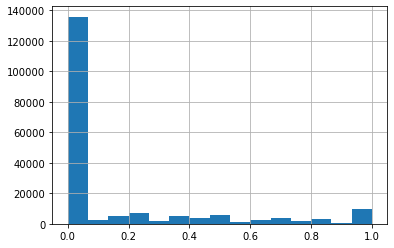

In [614]:
open_behavior_summary[open_behavior_summary['user_type']!='xo_users']['mpl_email_opened_rate'].hist(bins=15)

### Check what emails xo users opened

In [727]:
open_behavior[:3]

,user_id,campaign_name,user_type,dt,opens,clicks,unsubs,mpl,mpl_open,consumer_open
0,3406467,11232021 - Shop Houzz - Email,active_wo_xo,2021-11-23,0,0,0,1,0,0
1,3462567,11212021 - Shop Houzz - Email,active_wo_xo,2021-11-23,0,0,0,1,0,0
2,17424696,11232021 - Shop Houzz - Push,active_wo_xo,2021-11-23,0,0,0,1,0,0


In [731]:
open_behavior[(open_behavior['opens']>0)
             &(open_behavior['user_type']=='active_wo_xo')]['campaign_name'].value_counts()[:20]

newsletter_editorial_v1                       156580
trending-room-photo-email                      58320
community-interest-photo-email                 56363
community-interest-photo-email2                44279
interest-story-email                           42708
community-project-email                        42417
11212021 - Shop Houzz - Email                  19266
11182021 - Shop Houzz - Email                  18445
11232021 - Shop Houzz - Email                  15746
11142021 - Shop Houzz - Email                  12863
11112021 NEW - Shop Houzz - Email              12108
11092021 - Shop Houzz - Email                  10368
Cart Reminder - V3 - Email                      7053
Related Products/People Also Liked - Email      7026
Cart Reminder - V2 - Email                      5491
Cart Reminder V1 - Email 50/50                  5213
welcome_email                                   5095
price_drop_email                                4953
Price Drop Email                              

In [734]:
open_behavior[open_behavior['user_type']=='active_wo_xo']['user_id'].nunique()

190956

In [732]:
open_behavior[(open_behavior['opens']>0)
             &(open_behavior['user_type']!='active_wo_xo')]['campaign_name'].value_counts()[:20]

order_confirmation_email_us                            22730
order_shipped_email_us                                 15777
newsletter_editorial_v1                                10954
order_out_for_delivery_email_us                        10709
order_delivered_email_us                               10161
community-interest-photo-email                          3579
community-project-email                                 3523
trending-room-photo-email                               3214
Freq Bought Together - First Time Purchaser - Email     3127
11212021 - Shop Houzz - Email                           3067
community-interest-photo-email2                         2924
11182021 - Shop Houzz - Email                           2802
interest-story-email                                    2659
Freq Bought Together - Return Purchaser - Email         2576
11232021 - Shop Houzz - Email                           2562
MagicLinkEmail                                          2250
NewMessageEmail         

In [735]:
open_behavior[open_behavior['user_type']!='active_wo_xo']['user_id'].nunique()

31509

### Check freq bought together - first order with coupon LTV

In [625]:
q = '''
with users as(
select distinct user_id
from bls.blueshift_events
where campaign_name = 'Freq Bought Together With Holdout V3'
    and event_name = 'Email Delivered'
    and dt between '2021-05-01' and '2021-09-30'
)

select u.user_id
    , substring(m.created, 1, 7) yyyymm
    , count(distinct m.order_id) orders
    , sum(m.product_price) gmv
from users u
    left join mp.order_metrics_with_adjustments m
        on u.user_id = cast(m.user_id as varchar)
            and m.created >= '2021-09-01'
            and coupons_promotions != -25
group by 1,2

'''

In [626]:
%%time
users_w_coupon = pd.read_sql_query(q, conn)

users_w_coupon

CPU times: user 478 ms, sys: 1.67 s, total: 2.15 s
Wall time: 1min 20s


,user_id,yyyymm,orders,gmv
0,21237642,None,0,NaN
1,63676186,None,0,NaN
2,3646061,None,0,NaN
3,69113878,None,0,NaN
4,13442690,None,0,NaN
...,...,...,...,...
56476,69289958,None,0,NaN
56477,24401241,None,0,NaN
56478,41173455,None,0,NaN
56479,64856679,None,0,NaN


In [630]:
users_w_coupon[users_w_coupon['orders']!=0]['user_id'].nunique()

5881

In [629]:
users_w_coupon.user_id.nunique()

54893

In [631]:
5881/54893

0.10713570036252346

In [632]:
summary = users_w_coupon.groupby('yyyymm').agg({'user_id':pd.Series.nunique,'orders':'sum','gmv':'sum'}).reset_index()

In [633]:
summary

,yyyymm,user_id,orders,gmv
0,2021-09,3247,5299,1310412.140000
1,2021-10,2181,3903,1284691.580000
2,2021-11,1748,3266,1079102.750000
3,2021-12,293,458,148270.730000


In [634]:
summary['gmv_per_order'] = summary.apply(lambda x: x['gmv']/x['orders'],axis=1)

In [635]:
summary

,yyyymm,user_id,orders,gmv,gmv_per_order
0,2021-09,3247,5299,1310412.140000,247.294233
1,2021-10,2181,3903,1284691.580000,329.154901
2,2021-11,1748,3266,1079102.750000,330.405006
3,2021-12,293,458,148270.730000,323.735218


In [640]:
summary['user_id'].sum()-5881

1588

In [694]:
q = '''
with users as(
select distinct user_id
from bls.blueshift_events
where campaign_name = 'Freq Bought Together With Holdout V3'
    and event_name = 'Email Delivered'
    and dt between '2021-05-01' and '2021-09-30'
)

select u.user_id
    , count(distinct m.order_id) orders
    , sum(m.product_price) gmv
from users u
    left join mp.order_metrics_with_adjustments m
        on u.user_id = cast(m.user_id as varchar)
            and m.created >= '2021-10-01'
            and coupons_promotions != -25
group by 1

'''

In [695]:
%%time
users_w_coupon = pd.read_sql_query(q, conn)

users_w_coupon

CPU times: user 134 ms, sys: 58.1 ms, total: 193 ms
Wall time: 16.3 s


,user_id,orders,gmv
0,62515271,0,NaN
1,2996824,0,NaN
2,316131,0,NaN
3,69018081,0,NaN
4,68755271,0,NaN
...,...,...,...
54888,28559291,0,NaN
54889,68673809,0,NaN
54890,68673407,0,NaN
54891,3745490,0,NaN


In [696]:
users_w_coupon[users_w_coupon['orders']>0]

,user_id,orders,gmv
25,34503790,1,0.000000
32,69539052,1,152.000000
34,15898511,1,535.920000
39,50283294,2,86.000000
73,49258861,2,370.000000
...,...,...,...
54816,30246191,1,48.000000
54835,68732679,10,765.930000
54843,19322032,2,259.400000
54844,12803888,1,74.380000


In [652]:
users_w_coupon[users_w_coupon['orders']>0]['orders'].describe()

count   5881.000000
mean       2.197926
std        4.122809
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max      223.000000
Name: orders, dtype: float64

In [697]:
users_w_coupon[users_w_coupon['orders']>0]['user_id'].nunique()

3556

In [653]:
q = '''
with users as(
select distinct user_id
from bls.blueshift_events
where campaign_name = 'Freq Bought Together With Holdout V3'
    and event_name = 'Email Delivered'
    and dt between '2021-05-01' and '2021-09-30'
)

select u.user_id
from users u
    inner join l2.session_analytics l
        on u.user_id = cast(l.user_id as varchar)
where l.dt >= '2021-10-01'
group by u.user_id
having sum(browse_products) > 0

'''

In [654]:
%%time
active_users_w_coupon = pd.read_sql_query(q, conn)

active_users_w_coupon

CPU times: user 49 ms, sys: 8.58 ms, total: 57.6 ms
Wall time: 19.1 s


,user_id
0,4116537
1,34757470
2,42871660
3,52713232
4,8378597
...,...
10331,30680402
10332,63774383
10333,65017475
10334,42100348


In [655]:
10336/54893

0.1882935893465469

#### Limit windows to 14 days

In [689]:
q = '''
with users as(
select distinct user_id
from bls.blueshift_events
where campaign_name = 'Freq Bought Together With Holdout V3'
    and event_name = 'Email Delivered'
    and dt between '2021-05-01' and '2021-09-30'
), repeat_within_14_days as(
select distinct u.user_id
from users u
    inner join mp.order_item_margins_with_replacement m1
        on u.user_id = cast(m1.user_id as varchar)
            and m1.checkout_type = 'FIRST_UNCANCELLED_CHECKOUT'
    inner join mp.order_item_margins_with_replacement m2
        on u.user_id = cast(m2.user_id as varchar)
        and m2.checkout_type = 'REPEAT_CHECKOUT'
        and date_diff('day',date(substring(m1.created, 1, 10)),date(substring(m2.created, 1, 10))) between 0 and 14
)

select u.user_id
    , substring(m.created, 1, 7) yyyymm
    , count(distinct m.order_id) orders
    , sum(m.product_price) gmv
from repeat_within_14_days u
    left join mp.order_metrics_with_adjustments m
        on u.user_id = cast(m.user_id as varchar)
            and m.created >= '2021-10-01'
            and coupons_promotions != -25
group by 1,2

'''

In [690]:
%%time
users_w_coupon_2weeks = pd.read_sql_query(q, conn)

users_w_coupon_2weeks

CPU times: user 87.5 ms, sys: 40.7 ms, total: 128 ms
Wall time: 57.1 s


,user_id,yyyymm,orders,gmv
0,68613823,None,0,NaN
1,6510523,2021-10,2,182.990000
2,66952851,None,0,NaN
3,61393374,None,0,NaN
4,60122356,None,0,NaN
...,...,...,...,...
6134,25150609,2021-10,3,411.100000
6135,52201247,2021-10,3,1705.000000
6136,68950907,None,0,NaN
6137,23794516,None,0,NaN


In [691]:
users_w_coupon_2weeks[users_w_coupon_2weeks['orders']>0].describe()

,orders,gmv
count,863.000000,863.000000
mean,1.995365,591.093812
std,2.308559,1065.952658
min,1.000000,-1549.000000
25%,1.000000,89.500000
50%,1.000000,249.000000
75%,2.000000,648.935000
max,35.000000,12810.460000


In [692]:
users_w_coupon_2weeks['user_id'].nunique()

5957

In [693]:
users_w_coupon_2weeks[users_w_coupon_2weeks['gmv']>1]['user_id'].nunique()

622

In [686]:
users_w_coupon_2weeks.groupby('yyyymm').agg({'user_id':pd.Series.nunique,'orders':'sum','gmv':'sum'})

,user_id,orders,gmv
yyyymm,,,
2021-09,613,1175,266790.480000
2021-10,427,862,248300.640000
2021-11,367,750,224367.690000
2021-12,69,110,37445.630000


In [726]:
users_w_coupon_2weeks[users_w_coupon_2weeks['gmv']>0].describe()

,orders,gmv
count,768.000000,768.000000
mean,2.085938,683.000859
std,2.419588,1090.697613
min,1.000000,4.990000
25%,1.000000,133.750000
50%,1.000000,302.420000
75%,2.000000,736.955000
max,35.000000,12810.460000


In [668]:
q = '''
with users as(
select distinct user_id
from bls.blueshift_events
where campaign_name = 'Freq Bought Together With Holdout V3'
    and event_name = 'Email Delivered'
    and dt between '2021-05-01' and '2021-09-30'
), repeat_within_14_days as(
select distinct u.user_id
from users u
    inner join mp.order_item_margins_with_replacement m1
        on u.user_id = cast(m1.user_id as varchar)
            and m1.checkout_type = 'FIRST_UNCANCELLED_CHECKOUT'
    inner join mp.order_item_margins_with_replacement m2
        on u.user_id = cast(m2.user_id as varchar)
        and m2.checkout_type = 'REPEAT_CHECKOUT'
        and date_diff('day',date(substring(m1.created, 1, 10)),date(substring(m2.created, 1, 10))) between 0 and 14
)

select u.user_id
from repeat_within_14_days u
    inner join l2.session_analytics l
        on u.user_id = cast(l.user_id as varchar)
where l.dt >= '2021-10-01'
group by u.user_id
having sum(browse_products) > 0

'''

In [669]:
%%time
active_users_w_coupon_2weeks = pd.read_sql_query(q, conn)

active_users_w_coupon_2weeks

CPU times: user 130 ms, sys: 32 ms, total: 162 ms
Wall time: 1min 24s


,user_id
0,66581921
1,52113441
2,57038397
3,39173947
4,31390149
...,...
1517,55831575
1518,3355125
1519,15899811
1520,66333052


In [677]:
907/6363

0.14254282571114255

In [678]:
1522/6363

0.2391953481062392

In [666]:
q = '''
with users as(
select distinct user_id
from bls.blueshift_events
where campaign_name = 'Freq Bought Together With Holdout V3'
    and event_name = 'Email Delivered'
    and dt between '2021-05-01' and '2021-09-30'
), repeat_within_14_days as(
select distinct u.user_id
from users u
    inner join mp.order_item_margins_with_replacement m1
        on u.user_id = cast(m1.user_id as varchar)
            and m1.checkout_type = 'FIRST_UNCANCELLED_CHECKOUT'
    inner join mp.order_item_margins_with_replacement m2
        on u.user_id = cast(m2.user_id as varchar)
        and m2.checkout_type = 'REPEAT_CHECKOUT'
        and date_diff('day',date(substring(m1.created, 1, 10)),date(substring(m2.created, 1, 10))) between 0 and 14
    inner join mp.order_metrics_with_adjustments m
        on m2.order_id = m.order_id
            and coupons_promotions = -25
)

select u.user_id
    , substring(m.created, 1, 7) yyyymm
    , count(distinct m.order_id) orders
    , sum(m.product_price) gmv
from repeat_within_14_days u
    left join mp.order_metrics_with_adjustments m
        on u.user_id = cast(m.user_id as varchar)
            and m.created >= '2021-09-01'
            and coupons_promotions != -25
group by 1,2

'''

In [667]:
%%time
users_using_coupon_2weeks = pd.read_sql_query(q, conn)

users_using_coupon_2weeks

CPU times: user 137 ms, sys: 47.4 ms, total: 185 ms
Wall time: 1min 33s


,user_id,yyyymm,orders,gmv
0,69533556,None,0,NaN
1,68589227,None,0,NaN
2,68439313,None,0,NaN
3,69338193,None,0,NaN
4,55533047,2021-09,1,-182.990000
...,...,...,...,...
200,18404964,None,0,NaN
201,68207519,None,0,NaN
202,69267230,None,0,NaN
203,69497092,None,0,NaN


In [672]:
users_using_coupon_2weeks[users_using_coupon_2weeks['gmv']>1].shape[0]

35

In [704]:
q = '''
with users as(
select distinct user_id
from bls.blueshift_events
where campaign_name = 'Freq Bought Together With Holdout V3'
    and event_name = 'Email Delivered'
    and dt between '2021-05-01' and '2021-09-30'
), exclude_users as(
select distinct user_id
    , substring(created,1,10) dt
from mp.order_item_margins_with_replacement 
where cast(user_id as varchar) not in (select user_id from users)
    and checkout_type = 'FIRST_UNCANCELLED_CHECKOUT'
    and substring(created,1,10) between '2021-06-01' and '2021-08-31'
)

select u.user_id
    , substring(m.created, 1, 7) yyyymm
    , count(distinct m.order_id) orders
    , sum(m.product_price) gmv
from exclude_users u
    left join mp.order_metrics_with_adjustments m
        on u.user_id = m.user_id
            and substring(m.created, 1, 10) >= '2021-10-01'
group by 1,2

'''

In [705]:
%%time
exclude_users_xo = pd.read_sql_query(q, conn)

exclude_users_xo

CPU times: user 459 ms, sys: 828 ms, total: 1.29 s
Wall time: 13.3 s


,user_id,yyyymm,orders,gmv
0,4101924,None,0,NaN
1,68610261,None,0,NaN
2,66226568,None,0,NaN
3,68651987,None,0,NaN
4,67345933,None,0,NaN
...,...,...,...,...
87726,5842919,None,0,NaN
87727,68379079,None,0,NaN
87728,68972205,None,0,NaN
87729,69398222,None,0,NaN


In [707]:
exclude_users_xo['user_id'].nunique()

87297

In [708]:
exclude_users_xo[exclude_users_xo['gmv']>0]['user_id'].nunique()

2419

In [711]:
q = '''
with users as(
select distinct user_id
from bls.blueshift_events
where campaign_name = 'Freq Bought Together With Holdout V3'
    and event_name = 'Email Delivered'
    and dt between '2021-05-01' and '2021-09-30'
), exclude_users as(
select distinct user_id
    , substring(created,1,10) dt
from mp.order_item_margins_with_replacement 
where cast(user_id as varchar) not in (select user_id from users)
    and checkout_type = 'FIRST_UNCANCELLED_CHECKOUT'
    and substring(created,1,10) between '2021-06-01' and '2021-08-31'
)

select u.user_id
from exclude_users u
    inner join l2.session_analytics l
        on u.user_id = l.user_id
where l.dt >= '2021-10-01'
group by u.user_id
having sum(browse_products) > 0

'''

In [712]:
%%time
exclude_users_active = pd.read_sql_query(q, conn)

exclude_users_active

CPU times: user 43.6 ms, sys: 59.4 ms, total: 103 ms
Wall time: 17.1 s


,user_id
0,69156943
1,59951964
2,53063975
3,34547637
4,30548516
...,...
8906,69070961
8907,62611412
8908,998129
8909,69731038


In [719]:
q = '''
with users as(
select distinct user_id
from bls.blueshift_events
where campaign_name = 'Freq Bought Together With Holdout V3'
    and event_name = 'Email Delivered'
    and dt between '2021-05-01' and '2021-09-30'
), exclude_users as(
select distinct user_id
from mp.order_item_margins_with_replacement 
where cast(user_id as varchar) not in (select user_id from users)
    and checkout_type = 'FIRST_UNCANCELLED_CHECKOUT'
    and substring(created,1,10) between '2021-06-01' and '2021-08-31'
), repeat_within_14_days as(
select distinct u.user_id
from exclude_users u
    inner join mp.order_item_margins_with_replacement m1
        on u.user_id = m1.user_id
            and m1.checkout_type = 'FIRST_UNCANCELLED_CHECKOUT'
    inner join mp.order_item_margins_with_replacement m2
        on u.user_id = m2.user_id
        and m2.checkout_type = 'REPEAT_CHECKOUT'
        and date_diff('day',date(substring(m1.created, 1, 10)),date(substring(m2.created, 1, 10))) between 0 and 14
)

select u.user_id
    , substring(m.created, 1, 7) yyyymm
    , count(distinct m.order_id) orders
    , sum(m.product_price) gmv
from repeat_within_14_days u
    left join mp.order_metrics_with_adjustments m
        on u.user_id = m.user_id
            and m.created >= '2021-10-01'
            and coupons_promotions != -25
group by 1,2

'''

In [720]:
%%time
exclude_users_repeat_purchase = pd.read_sql_query(q, conn)

exclude_users_repeat_purchase

CPU times: user 36 ms, sys: 42.5 ms, total: 78.5 ms
Wall time: 10.8 s


,user_id,yyyymm,orders,gmv
0,69315857,None,0,NaN
1,68837072,2021-10,6,341.790000
2,68837072,2021-11,3,231.620000
3,68837072,2021-12,1,104.170000
4,60500597,2021-10,1,0.000000
...,...,...,...,...
4271,1809825,None,0,NaN
4272,68562661,None,0,NaN
4273,53683671,2021-11,1,231.000000
4274,53683671,2021-10,1,530.000000


In [721]:
exclude_users_repeat_purchase['user_id'].nunique()

4170

In [722]:
exclude_users_repeat_purchase[exclude_users_repeat_purchase['gmv']>0]['user_id'].nunique()

375

In [723]:
exclude_users_repeat_purchase[exclude_users_repeat_purchase['gmv']>0].describe()

,user_id,orders,gmv
count,453.000000,453.000000,453.000000
mean,55159147.123620,1.977925,597.880419
std,21770119.125762,1.778547,1266.728043
min,382857.000000,1.000000,12.090000
25%,50854969.000000,1.000000,139.010000
50%,68522700.000000,1.000000,286.000000
75%,69456026.000000,2.000000,580.200000
max,69758924.000000,22.000000,18975.000000


In [724]:
q = '''
with users as(
select distinct user_id
from bls.blueshift_events
where campaign_name = 'Freq Bought Together With Holdout V3'
    and event_name = 'Email Delivered'
    and dt between '2021-05-01' and '2021-09-30'
), exclude_users as(
select distinct user_id
from mp.order_item_margins_with_replacement 
where cast(user_id as varchar) not in (select user_id from users)
    and checkout_type = 'FIRST_UNCANCELLED_CHECKOUT'
    and substring(created,1,10) between '2021-06-01' and '2021-08-31'
), repeat_within_14_days as(
select distinct u.user_id
from exclude_users u
    inner join mp.order_item_margins_with_replacement m1
        on u.user_id = m1.user_id
            and m1.checkout_type = 'FIRST_UNCANCELLED_CHECKOUT'
    inner join mp.order_item_margins_with_replacement m2
        on u.user_id = m2.user_id
        and m2.checkout_type = 'REPEAT_CHECKOUT'
        and date_diff('day',date(substring(m1.created, 1, 10)),date(substring(m2.created, 1, 10))) between 0 and 14
)

select u.user_id
from repeat_within_14_days u
    inner join l2.session_analytics l
        on u.user_id = l.user_id
where l.dt >= '2021-10-01'
group by u.user_id
having sum(browse_products) > 0
'''

In [725]:
%%time
exclude_users_repeat_purchase_active = pd.read_sql_query(q, conn)

exclude_users_repeat_purchase_active

CPU times: user 38.9 ms, sys: 17.6 ms, total: 56.5 ms
Wall time: 20.3 s


,user_id
0,69520656
1,68605435
2,64402075
3,69157861
4,69193504
...,...
870,48391331
871,69723934
872,69649513
873,69644390
